In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib
from xgboost import XGBRegressor
from scipy.stats import uniform, randint

In [85]:
# Load the dataset
data = pd.read_csv(r'C:\Users\varad\Downloads\clean_data.csv')

# Step 1: Data Preprocessing
# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sort by Date to maintain chronological order
data = data.sort_values('Date')

# Encode categorical variables
label_encoders = {}
for col in ['Type', 'Store', 'Dept']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Feature Engineering
# Add day_of_week and is_weekend features
data['day_of_week'] = data['Date'].dt.dayofweek
data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)

# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0', 'Date']
data = data.drop(columns=columns_to_drop, axis=1)

# Separate features and target
X = data.drop('Weekly_Sales', axis=1)
y = data['Weekly_Sales']

# Scale numerical features
numerical_features = ['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size', ]
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])



ValueError: time data "19-02-2010" doesn't match format "%m-%d-%Y", at position 2. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [23]:
# Step 2: Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [25]:
# Step 3: Hyperparameter Tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Initialize XGBoost regressor with GPU settings
xgb_model = XGBRegressor(
    random_state=42,
    tree_method='gpu_hist',  # Use GPU-based algorithm
    gpu_id=0,  # Use GPU 0, change if you have multiple GPUs
    predictor='gpu_predictor'  # Use GPU for prediction
)


In [ ]:
random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_dist, 
    n_iter=100, 
    n_jobs=-1, 
    random_state=42,
    verbose=1, 
    scoring='neg_mean_squared_error',
    cv=5
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score
print("Best hyperparameters found: ", random_search.best_params_)
print("Best cross-validation score: ", -random_search.best_score_)

# Get the best model from the random search
best_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [13]:
# Step 4: Evaluate the Model
# Predict on the test set with the best model
y_pred_best = best_model.predict(X_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Test RMSE: {rmse_best}")
print(f"Test MAE: {mae_best}")
print(f"Test R^2 Score: {r2_best}")

# Visualization of Metrics for the Best Model
# metrics_best = {'RMSE': rmse_best, 'MAE': mae_best, 'R^2': r2_best}
# plt.bar(metrics_best.keys(), metrics_best.values(), color=['blue', 'orange', 'green'])
# plt.title('Best Model Evaluation Metrics')
# plt.ylabel('Score')
# plt.show()

# Visualization of Predictions vs Actuals
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Sales', color='blue', alpha=0.7)
plt.plot(y_pred_best, label='Predicted Sales', color='orange', alpha=0.7)
plt.title('Predictions vs Actual Sales')
plt.xlabel('Test Samples')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

# Step 5: Save the Best Model
joblib.dump(best_model, 'sales_forecasting_xgb_best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

# Step 6: Make Predictions with the Best Model
# Example: Predict for the last available period in the test set
last_data = X_test.tail(1)
predicted_sales_best = best_model.predict(last_data)
print(f"Predicted Sales for the last test record: {predicted_sales_best[0]}")

NameError: name 'best_model' is not defined

         Date  Predicted_Sales
0  2012-11-02       520.331299
1  2012-11-09       591.778320
2  2012-11-16      1003.618530
3  2012-11-23      1617.307129
4  2012-11-30      1392.432251
5  2012-12-07      1810.239746
6  2012-12-14      1663.531372
7  2012-12-21      2686.180664
8  2012-12-28      2046.609253
9  2013-01-04        83.408722
10 2013-01-11       748.340637
11 2013-01-18       885.420471
12 2013-01-25        41.990089
13 2013-02-01      1267.570435
14 2013-02-08      1278.281006
15 2013-02-15      1481.346436
16 2013-02-22       746.087524
17 2013-03-01       830.433350
18 2013-03-08      1272.231689
19 2013-03-15      1702.421875
20 2013-03-22       792.404785
21 2013-03-29       905.255249
22 2013-04-05      1643.559448
23 2013-04-12      1446.276001
24 2013-04-19      1493.341919
25 2013-04-26       749.558228
26 2013-05-03      1774.384033
27 2013-05-10      1673.063965
28 2013-05-17      1384.517212
29 2013-05-24      1665.717896
30 2013-05-31      1769.758423
31 2013-

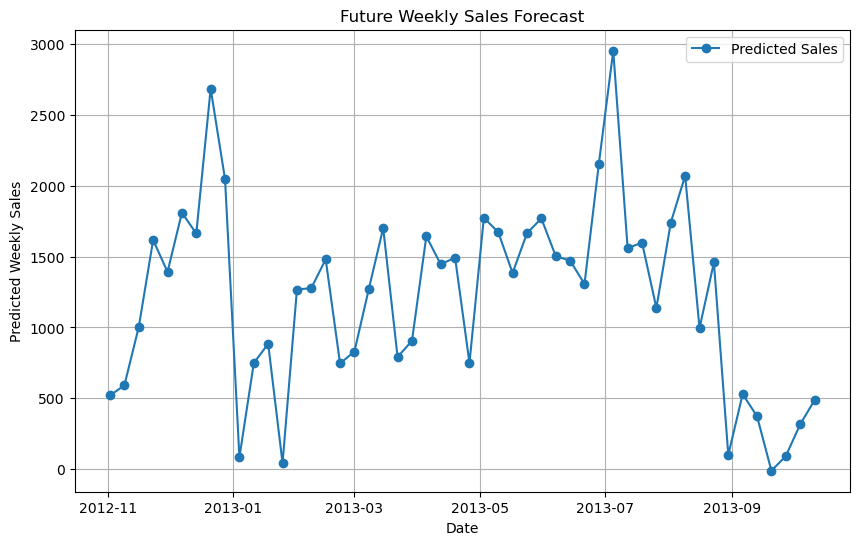

In [5]:
import pandas as pd
import numpy as np
import joblib
from datetime import timedelta

# Step 1: Load the Trained Model and Preprocessing Objects
model = joblib.load('sales_forecasting_xgb_best_model.pkl')
scaler = joblib.load('scaler.pkl')
label_encoders = joblib.load('label_encoders.pkl')

# Step 2: Prepare the Starting Point for Predictions
# Load the dataset to extract the last known state for feature generation
data = pd.read_csv(r'C:\Users\varad\Downloads\clean_data.csv')

# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

# Get the last row of data to start predictions
last_row = data.iloc[-1].copy()

# Number of weeks to forecast
weeks_to_forecast = 50# Change this number as needed

# Initialize a DataFrame to store future predictions
future_predictions = []

# Step 3: Generate Future Predictions Iteratively
for week in range(weeks_to_forecast):
    # Increment the date by 1 week
    last_row['Date'] += timedelta(weeks=1)
    
    # Update features for the new week
    last_row['day_of_week'] = last_row['Date'].dayofweek
    last_row['is_weekend'] = 1 if last_row['day_of_week'] >= 5 else 0
    last_row['week'] = last_row['Date'].week
    last_row['month'] = last_row['Date'].month
    last_row['year'] = last_row['Date'].year
    
    # Prepare the input for prediction
    input_data = last_row.drop(['Weekly_Sales', 'Unnamed: 0', 'Date'], errors='ignore')
    
    # Encode categorical variables
    for col, le in label_encoders.items():
        input_data[col] = le.transform([input_data[col]])[0]
    
    # Convert input_data to a DataFrame for scaling
    input_data = pd.DataFrame([input_data])
    
    # Scale numerical features
    input_data[numerical_features] = scaler.transform(input_data[numerical_features])
    
    # Predict sales for the next week
    weekly_sales = model.predict(input_data)[0]
    future_predictions.append({'Date': last_row['Date'], 'Predicted_Sales': weekly_sales})
    
    # Update the last_row with the predicted value for continuity (if necessary)
    last_row['Weekly_Sales'] = weekly_sales


# Step 4: Convert Predictions to DataFrame and Save
future_df = pd.DataFrame(future_predictions)
print(future_df)

# Optional: Save the future predictions to a CSV file
future_df.to_csv('future_sales_predictions.csv', index=False)

# Visualization (Optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(future_df['Date'], future_df['Predicted_Sales'], label='Predicted Sales', marker='o')
plt.title('Future Weekly Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Predicted Weekly Sales')
plt.grid(True)
plt.legend()
plt.show()


R^2 Score: -5.95761008423105


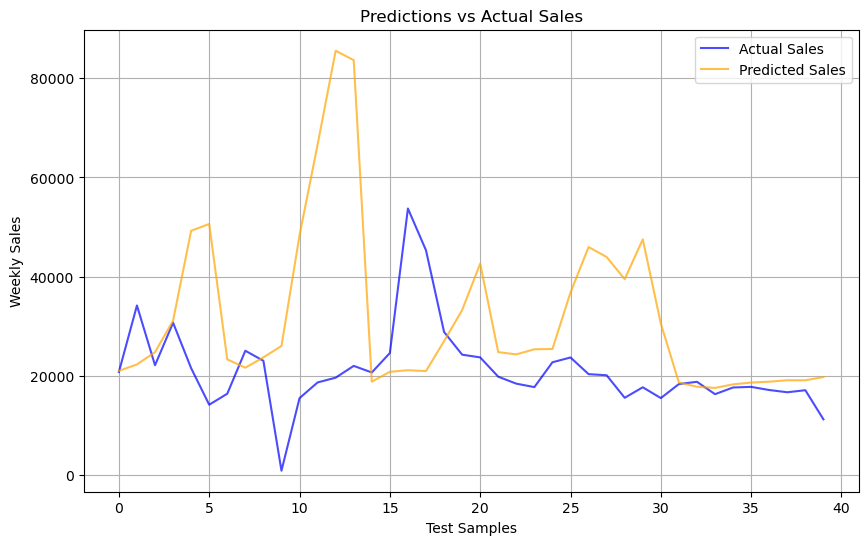

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import joblib
import matplotlib.pyplot as plt

# Load the weekly sales dataset
data = pd.read_csv(r'C:\Users\varad\Downloads\weekly_sales.csv')

# Load the pretrained model and identify expected features
model = joblib.load('sales_forecasting_xgb_best_model.pkl')
expected_features = ['Store', 'Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 
                     'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 
                     'Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas', 'week', 'month', 'year', 
                     'day_of_week', 'is_weekend']

# Convert Week column to datetime (assuming week format is 'YYYY-WW')
data['Date'] = pd.to_datetime(data['Week'] + '-1', format='%Y-%U-%w')
data = data.sort_values('Date')

# Generate features available in the dataset
X = pd.DataFrame()
X['day_of_week'] = data['Date'].dt.dayofweek
X['is_weekend'] = (X['day_of_week'] >= 5).astype(int)
X['week'] = data['Date'].dt.isocalendar().week.astype(int)
X['month'] = data['Date'].dt.month
X['year'] = data['Date'].dt.year

# Add missing features with default values (0 or NaN as placeholders)
for feature in expected_features:
    if feature not in X.columns:
        X[feature] = 0  # Default value, adjust if needed

# Align the feature order with the model's expectations
X = X[expected_features]

y = data['Total Sales Amount (RMB)']

# Split data into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate R^2 score
r2 = r2_score(y_test, y_pred)

# Output the results
print(f"R^2 Score: {r2}")

# Visualization of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Sales', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Sales', color='orange', alpha=0.7)
plt.title('Predictions vs Actual Sales')
plt.xlabel('Test Samples')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()


Feature Importance:
         Feature  Importance
1           Dept     31722.0
0          Store     10781.0
3    Temperature      7947.0
13          Size      7887.0
18          week      7581.0
10           CPI      6706.0
4     Fuel_Price      5921.0
11  Unemployment      5085.0
7      MarkDown3      1521.0
5      MarkDown1      1427.0
12          Type      1292.0
8      MarkDown4      1167.0
9      MarkDown5      1155.0
6      MarkDown2      1049.0
2      IsHoliday       752.0
16  Thanksgiving       316.0
19         month       283.0
17     Christmas       223.0
20          year       115.0
14    Super_Bowl       112.0
15     Labor_Day        78.0

Missing Features:
['Store', 'Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas', 'week', 'month', 'year', 'day_of_week', 'is_weekend']

Important Features Missing in Dataset:
['Dept', 

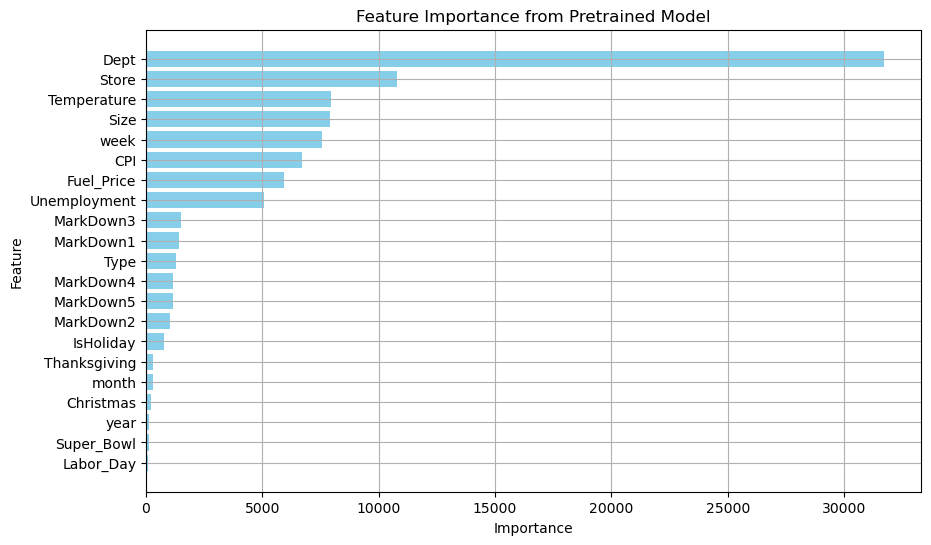

In [3]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# Load the pretrained model
model = joblib.load('sales_forecasting_xgb_best_model.pkl')

# Extract feature importance from the model
feature_importance = model.get_booster().get_score(importance_type='weight')
feature_importance = pd.DataFrame({
    'Feature': feature_importance.keys(),
    'Importance': feature_importance.values()
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Load your dataset
data = pd.read_csv(r'C:\Users\varad\Downloads\weekly_sales.csv')

# Extract features available in your dataset
dataset_features = data.columns

# Identify missing features
expected_features = ['Store', 'Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
                     'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size',
                     'Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas', 'week', 'month', 'year',
                     'day_of_week', 'is_weekend']

missing_features = [feature for feature in expected_features if feature not in dataset_features]
print("\nMissing Features:")
print(missing_features)

# Compare feature importance and dataset features
important_features = feature_importance['Feature'].tolist()
important_missing = [feature for feature in important_features if feature in missing_features]
print("\nImportant Features Missing in Dataset:")
print(important_missing)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Pretrained Model')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


R^2 Score (Retrained): -0.048276857207664614


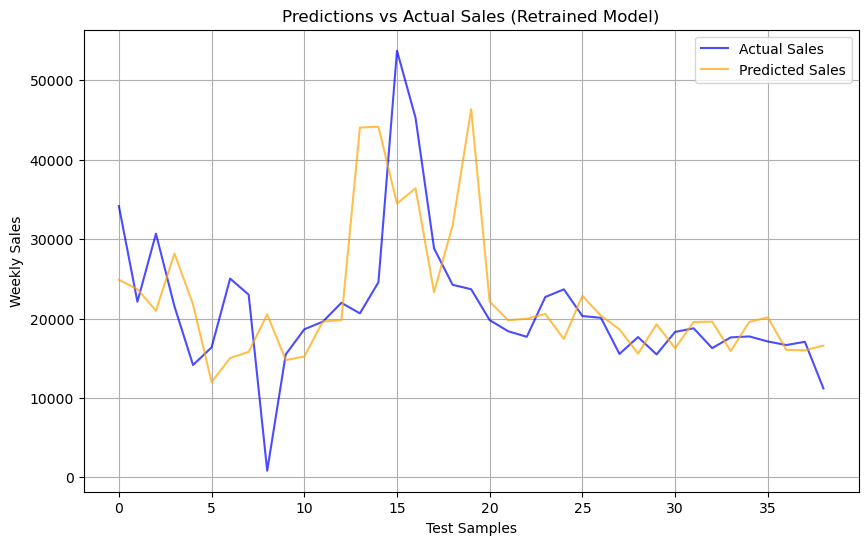

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Load the weekly sales dataset
data = pd.read_csv(r'C:\Users\varad\Downloads\weekly_sales.csv')

# Convert Week column to datetime (assuming week format is 'YYYY-WW')
data['Date'] = pd.to_datetime(data['Week'] + '-1', format='%Y-%U-%w')
data = data.sort_values('Date')

# Create lagged features
data['Lag_1'] = data['Total Sales Amount (RMB)'].shift(1)
data['Lag_2'] = data['Total Sales Amount (RMB)'].shift(2)
data['Lag_3'] = data['Total Sales Amount (RMB)'].shift(3)

# Drop rows with NaN values from lagged features
data = data.dropna()

# Generate additional features
X = pd.DataFrame()
X['Lag_1'] = data['Lag_1']
X['Lag_2'] = data['Lag_2']
X['Lag_3'] = data['Lag_3']
X['week'] = data['Date'].dt.isocalendar().week.astype(int)
X['month'] = data['Date'].dt.month
X['year'] = data['Date'].dt.year

y = data['Total Sales Amount (RMB)']

# Split data into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

# Train a new model
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate R^2 score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score (Retrained): {r2}")

# Visualization of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Sales', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Sales', color='orange', alpha=0.7)
plt.title('Predictions vs Actual Sales (Retrained Model)')
plt.xlabel('Test Samples')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()


R^2 Score (Retrained): 0.7251763884830404


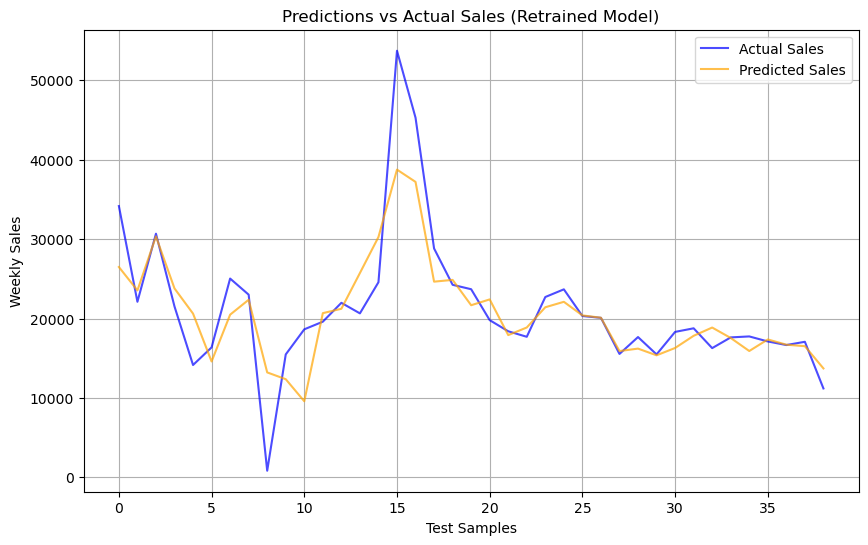

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Load the weekly sales dataset
data = pd.read_csv(r'C:\Users\varad\Downloads\weekly_sales.csv')

# Convert Week column to datetime (assuming week format is 'YYYY-WW')
data['Date'] = pd.to_datetime(data['Week'] + '-1', format='%Y-%U-%w')
data = data.sort_values('Date')

# Create lagged features
data['Lag_1'] = data['Total Sales Amount (RMB)'].shift(1)
data['Lag_2'] = data['Total Sales Amount (RMB)'].shift(2)
data['Lag_3'] = data['Total Sales Amount (RMB)'].shift(3)
data['Rolling_Mean_3'] = data['Total Sales Amount (RMB)'].rolling(window=3).mean()
data['Rolling_Sum_3'] = data['Total Sales Amount (RMB)'].rolling(window=3).sum()

# Drop rows with NaN values from lagged and rolling features
data = data.dropna()

# Generate additional features
X = pd.DataFrame()
X['Lag_1'] = data['Lag_1']
X['Lag_2'] = data['Lag_2']
X['Lag_3'] = data['Lag_3']
X['Rolling_Mean_3'] = data['Rolling_Mean_3']
X['Rolling_Sum_3'] = data['Rolling_Sum_3']
X['week'] = data['Date'].dt.isocalendar().week.astype(int)
X['month'] = data['Date'].dt.month
X['year'] = data['Date'].dt.year
X['is_weekend'] = (data['Date'].dt.dayofweek >= 5).astype(int)

# Target variable
y = data['Total Sales Amount (RMB)']

# Split data into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

# Train a new model
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate R^2 score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score (Retrained): {r2}")

# Visualization of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Sales', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Sales', color='orange', alpha=0.7)
plt.title('Predictions vs Actual Sales (Retrained Model)')
plt.xlabel('Test Samples')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()


R^2 Score (Retrained): 0.7251763884830404


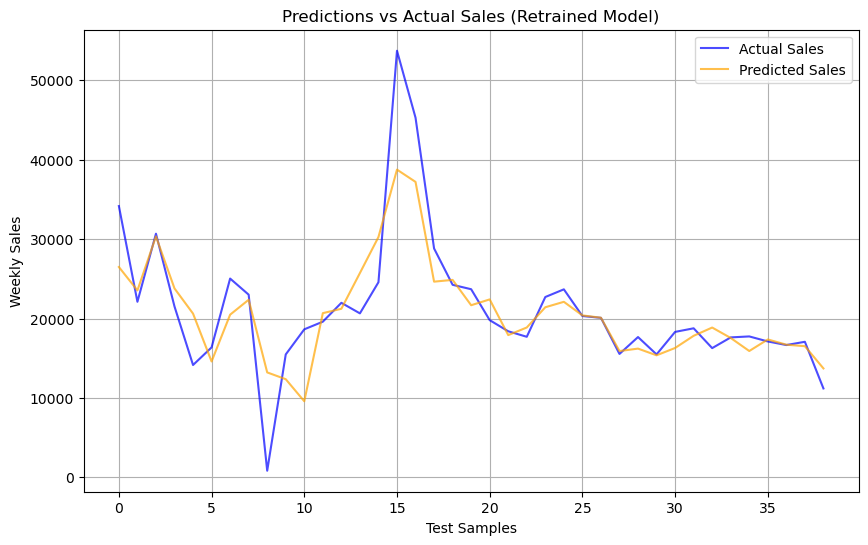

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Load the weekly sales dataset
data = pd.read_csv(r'C:\Users\varad\Downloads\weekly_sales.csv')

# Convert Week column to datetime (assuming week format is 'YYYY-WW')
data['Date'] = pd.to_datetime(data['Week'] + '-1', format='%Y-%U-%w')
data = data.sort_values('Date')

# Create lagged features
data['Lag_1'] = data['Total Sales Amount (RMB)'].shift(1)
data['Lag_2'] = data['Total Sales Amount (RMB)'].shift(2)
data['Lag_3'] = data['Total Sales Amount (RMB)'].shift(3)
data['Rolling_Mean_3'] = data['Total Sales Amount (RMB)'].rolling(window=3).mean()
data['Rolling_Sum_3'] = data['Total Sales Amount (RMB)'].rolling(window=3).sum()

# Drop rows with NaN values from lagged and rolling features
data = data.dropna()

# Generate additional features
X = pd.DataFrame()
X['Lag_1'] = data['Lag_1']
X['Lag_2'] = data['Lag_2']
X['Lag_3'] = data['Lag_3']
X['Rolling_Mean_3'] = data['Rolling_Mean_3']
X['Rolling_Sum_3'] = data['Rolling_Sum_3']
X['week'] = data['Date'].dt.isocalendar().week.astype(int)
X['month'] = data['Date'].dt.month
X['year'] = data['Date'].dt.year
X['is_weekend'] = (data['Date'].dt.dayofweek >= 5).astype(int)



# Target variable
y = data['Total Sales Amount (RMB)']

# Split data into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

# Train a new model
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate R^2 score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score (Retrained): {r2}")

# Visualization of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Sales', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Sales', color='orange', alpha=0.7)
plt.title('Predictions vs Actual Sales (Retrained Model)')
plt.xlabel('Test Samples')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()


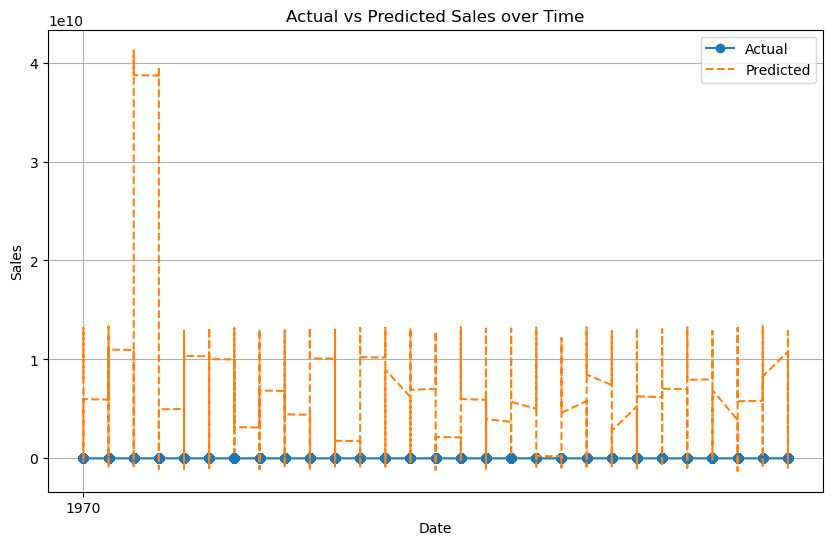

Linear Regression coefficients: [ 0.00000000e+00 -8.23357814e+04  7.75160315e+04  1.12150888e+04
  1.17422767e+02  2.16538071e+03  8.14505973e+02  1.56810218e+03
 -5.16231765e+02  7.70433669e+04 -3.05424320e+01  9.63136531e+03
 -2.33116048e+03 -1.76105317e+03  1.59722347e+03  1.90984198e+04
  5.20979276e+02 -4.03556509e+02  0.00000000e+00  0.00000000e+00]
Linear Regression intercept: 3305.6817086035644
Linear Regression R² score on test set: 0.029249758110636126


In [169]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler, LabelEncoder
# from sklearn.linear_model import LinearRegression
# import matplotlib.pyplot as plt

# # Load the dataset dynamically
# file_path = r'C:\Users\varad\Downloads\weekly_sales.csv'
# data = pd.read_csv(file_path)
# date = []
# for column in data.columns:
#     try:
#         data[column] = pd.to_datetime(data[column], format='%d-%m-%Y')
#         data['year'] = data[column].dt.year
#         data['month'] = data[column].dt.month
#         data['day'] = data[column].dt.day
#         data['weekday'] = data[column].dt.weekday
#         date.append('year', 'month', 'day','weekday')
#     except Exception as e:
#         continue


# for column in data.columns:
#     if data[column].dtype == 'bool':  # Check if the column is boolean
#         data[column] = data[column].astype(int)  # Convert to 1/0
#     elif data[column].dtype == 'object':  # Check if the column is string-like or datetime
#             label_encoder = LabelEncoder()
#             data[column] = label_encoder.fit_transform(data[column])  # Encode string categories into numbers
#             # Keep the original categorical 
#     elif np.issubdtype(data[column].dtype, np.number):  # Normalize numeric columns
#         data[column] = MinMaxScaler().fit_transform(data[[column]])





# dependent_column = input("Enter the dependent (target) column name: ")
# independent_columns = ['Week']+date





# # Extract dependent and independent variables
# X = data[independent_columns]
# y = data[dependent_column]

# # Normalize the independent variables (if not already normalized)
# scaler = MinMaxScaler()
# X_normalized = scaler.fit_transform(X)


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load the dataset dynamically
file_path = r'C:\Users\varad\Downloads\clean_data.csv'
data = pd.read_csv(file_path)

# for column in data.columns:
#     try:
#         data[column] = pd.to_datetime(data[column], format='%d-%m-%Y')
#         data['year'] = data[column].dt.year
#         data['month'] = data[column].dt.month
#         data['day'] = data[column].dt.day
#         data['weekday'] = data[column].dt.weekday
#         date.append('year', 'month', 'day','weekday')
#     except Exception as e:
#         continue

# Automatically detect and convert True/False columns to 1/0
for column in data.columns:
    if data[column].dtype == 'bool':  # Check if the column is boolean
        data[column] = data[column].astype(int)  # Convert to 1/0
    elif data[column].dtype == 'object':  # Check if the column is string-like or datetime
            label_encoder = LabelEncoder()
            data[column] = label_encoder.fit_transform(data[column])  # Encode string categories into numbers
            # Keep the original categorical 
    elif np.issubdtype(data[column].dtype, np.number):  # Normalize numeric columns
        if column != 'Sales':  # Avoid normalizing 'Sales'
            scaler = MinMaxScaler()
            data[column] = scaler.fit_transform(data[[column]])

# Define features and target (date as time and other data on that day)
time_column = 'Date'  # Assuming 'Date' is the time variable (day)
dependent_column = 'Sales'  # The dependent variable you want to predict

# Prepare independent (X) and dependent (y) variables
X = data.drop(columns=[time_column, dependent_column])  # Features other than 'Date' and 'Sales'
y = data[dependent_column]  # The target variable (Sales)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Sort by 'Date' to ensure temporal order
data = data.sort_values(by='Date')

# Prepare the dataset with time as a sequential variable
# Create day indices as numerical time-series values
data['DayIndex'] = (data['Date'] - data['Date'].min()).dt.days

# Split into train and test sets based on temporal order
X = data[['DayIndex'] + list(X.columns)]  # Use 'DayIndex' as time-based feature + other data
y = data[dependent_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)  # Use chronological split

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Denormalize the predictions
# Fit the scaler on the training set (X_train)
scaler_y = MinMaxScaler()
scaler_y.fit(y_train.values.reshape(-1, 1))

# Predict on test set
y_pred = model.predict(X_test)

# Denormalize the predictions
y_pred_denormalized = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(data['Date'].iloc[:len(y_test)], y_test, label='Actual', marker='o')
plt.plot(data['Date'].iloc[:len(y_test)], y_pred_denormalized, label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales over Time')
plt.legend()
plt.grid(True)
plt.show()

# Print model performance
print("Linear Regression coefficients:", model.coef_)
print("Linear Regression intercept:", model.intercept_)
print("Linear Regression R² score on test set:", model.score(X_test, y_test))



Mean Squared Error: 46074384.10
R2: 0.42403602569040655


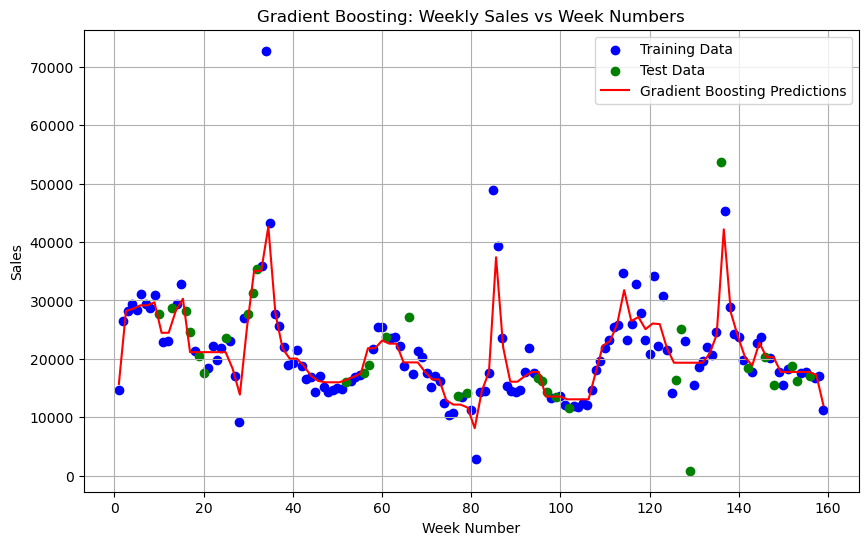

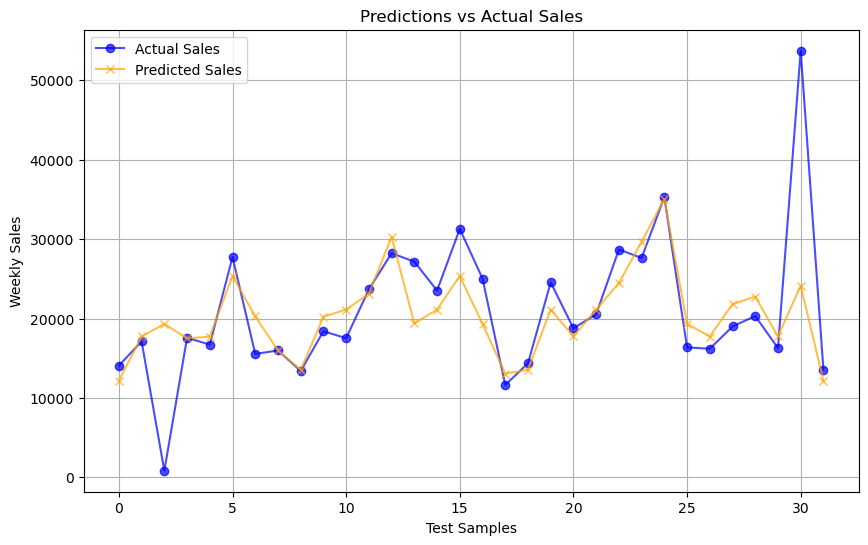

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Sample dataset (replace with your dataset)
data = pd.read_csv(r'C:\Users\varad\Downloads\weekly_sales.csv')
df = pd.DataFrame(data)

# Features (X) and target (y)
X = df[['Week']].values
y = df['Sales'].values

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Gradient Boosting model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
r2 = r2_score(y_test, y_pred)
print("R2:",r2)

# Plot the training data, test data, and predictions
plt.figure(figsize=(10, 6))

# Scatter plot for actual data
plt.scatter(X_train, y_train, color='blue', label='Training Data')
plt.scatter(X_test, y_test, color='green', label='Test Data')

# Plot the prediction line
X_line = np.linspace(df['Week'].min(), df['Week'].max(), 100).reshape(-1, 1)
y_line = model.predict(X_line)
plt.plot(X_line, y_line, color='red', label='Gradient Boosting Predictions')

plt.title('Gradient Boosting: Weekly Sales vs Week Numbers')
plt.xlabel('Week Number')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

# Plotting the actual vs predicted sales
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Actual Sales", color="blue", alpha=0.7, marker="o")
plt.plot(y_pred, label="Predicted Sales", color="orange", alpha=0.7, marker="x")
plt.title("Predictions vs Actual Sales")
plt.xlabel("Test Samples")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()


Feature Importances: [0.3834913  0.22949515 0.17998318 0.20703037]
Mean Squared Error: 279904655.64160234
R-squared Score: -0.02888004475418593


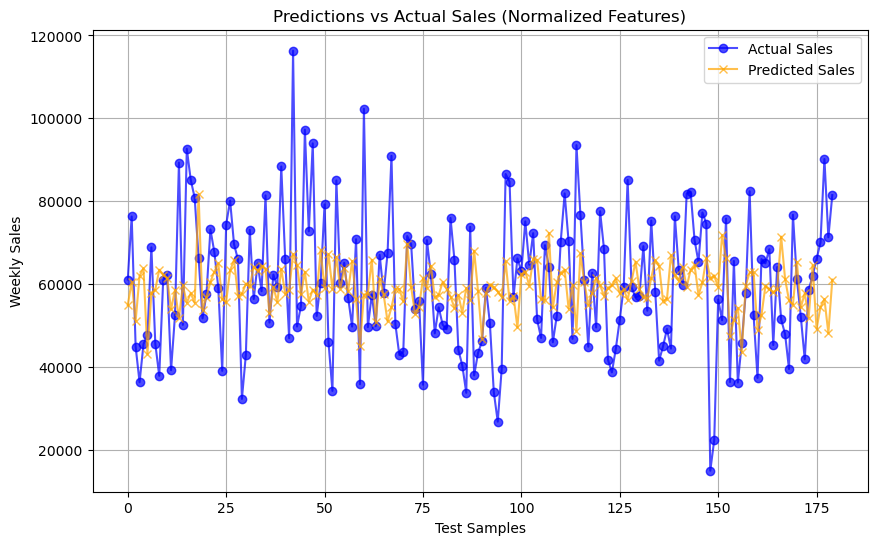

In [46]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset
data = pd.read_csv(r'C:\Users\varad\OneDrive\Documents\archive_(5)[1]\Stores.csv')

# Create DataFrame
df = pd.DataFrame(data)

# Features and target variable
X_normalized = scaler.fit_transform(X)
X = df[["Week", "Daily_Customer_Count", "Store_Area", "Items_Available"]]  # Feature columns
y = df["Sales"]  # Target

# Normalize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Initialize and train the Gradient Boosting model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Feature Importances:", model.feature_importances_)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Plot actual vs predicted sales
plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label="Actual Sales", color="blue", alpha=0.7, marker="o")
plt.plot(y_pred, label="Predicted Sales", color="orange", alpha=0.7, marker="x")
plt.title("Predictions vs Actual Sales (Normalized Features)")
plt.xlabel("Test Samples")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()


--- Linear Regression ---
Mean Squared Error: 74641037.68779638
R-squared Score: 0.06693166816179696


AttributeError: 'numpy.ndarray' object has no attribute 'reset_index'

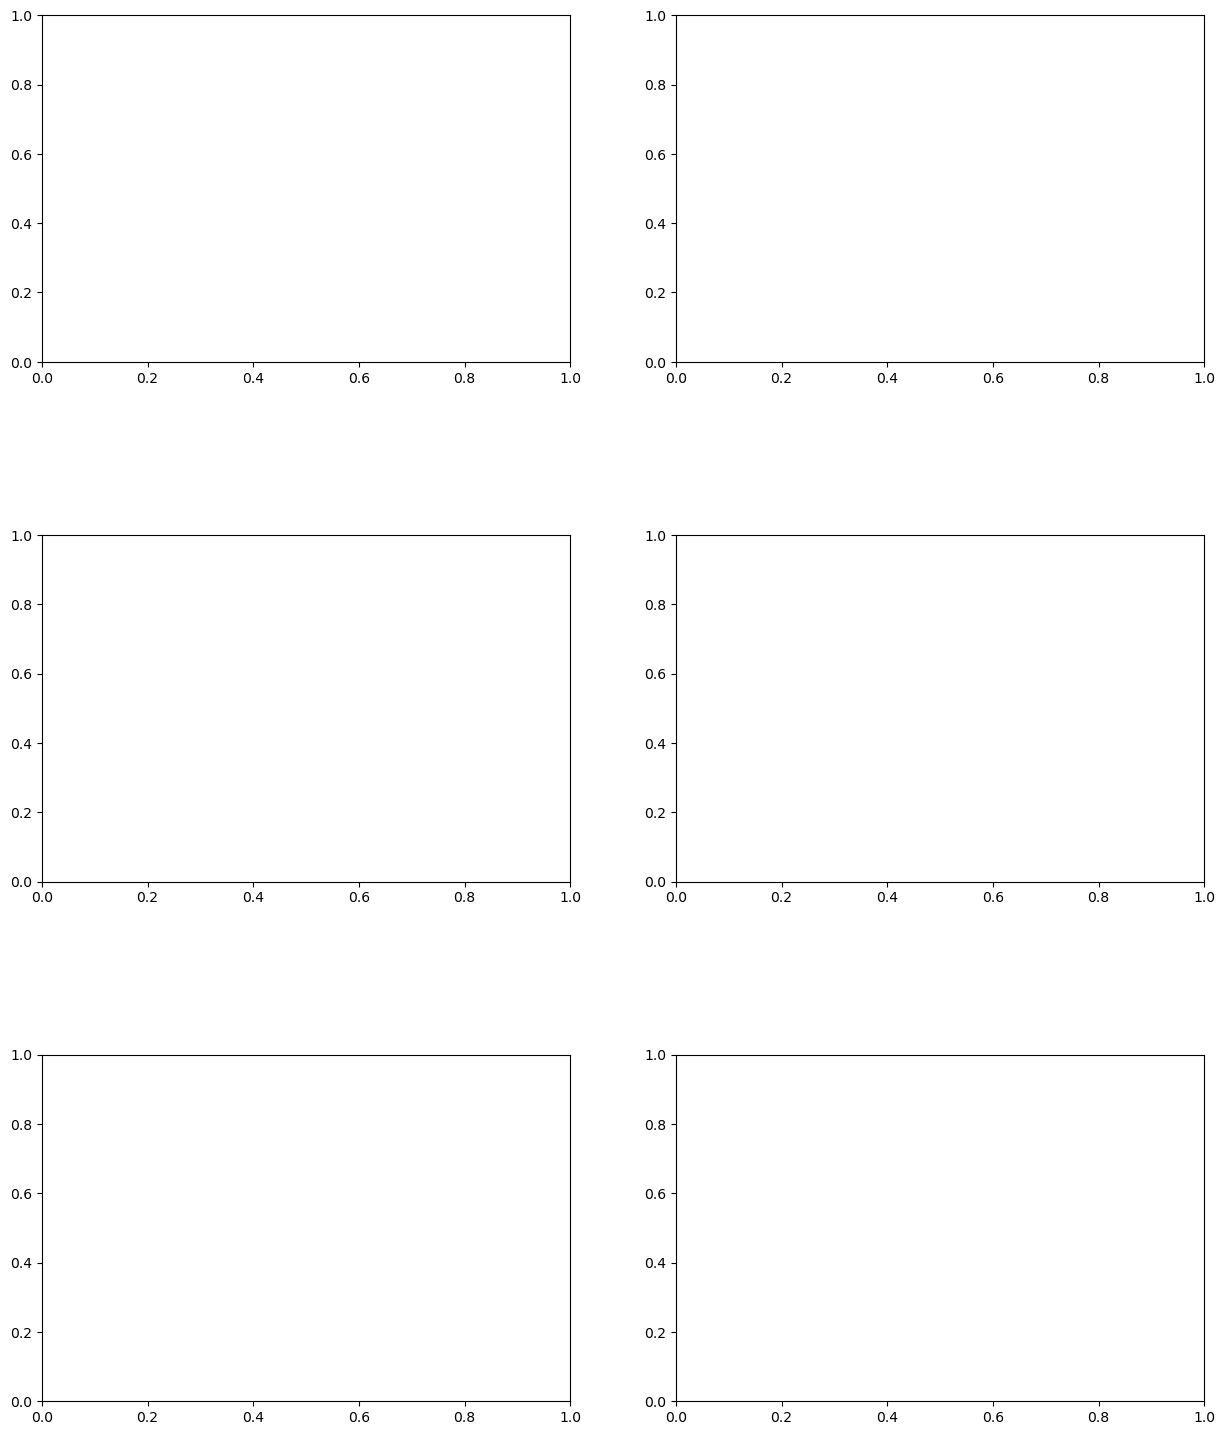

In [66]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset
data = pd.read_csv(r'C:\Users\varad\OneDrive\Documents\archive_(5)[1]\Stores.csv')

# Create DataFrame
df = pd.DataFrame(data)

# Features and target variable
X = df[["Week", "Daily_Customer_Count", "Store_Area", "Items_Available"]]  # Feature columns
y = df["Sales"]  # Target

# Normalize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Define regression models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "SVR": SVR(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "XGBoost Regressor": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Train and test each model
fig, axs = plt.subplots(3, 2, figsize=(15, 18))
plt.subplots_adjust(hspace=0.5)

for idx, (name, model) in enumerate(models.items()):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"--- {name} ---")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    
    # Plot actual vs predicted sales
    ax = axs[idx // 2, idx % 2]
    ax.plot(y_test.reset_index(drop=True), label="Actual Sales", color="blue", alpha=0.7, marker="o")
    ax.plot(y_pred, label="Predicted Sales", color="orange", alpha=0.7, marker="x")
    ax.set_title(f"Predictions vs Actual Sales ({name})")
    ax.set_xlabel("Test Samples")
    ax.set_ylabel("Weekly Sales")
    ax.legend()
    ax.grid(True)

plt.show()


Fitting 5 folds for each of 1 candidates, totalling 5 fits
--- Linear Regression ---
Best Params: {}
Mean Squared Error: 74641037.68779638
R-squared Score: 0.06693166816179696
Fitting 5 folds for each of 3 candidates, totalling 15 fits
--- Ridge Regression ---
Best Params: {'alpha': 10.0}
Mean Squared Error: 74904252.29506099
R-squared Score: 0.06364129034653798
Fitting 5 folds for each of 3 candidates, totalling 15 fits
--- Lasso Regression ---
Best Params: {'alpha': 1.0}
Mean Squared Error: 74643581.272419
R-squared Score: 0.06689987146745513
Fitting 5 folds for each of 9 candidates, totalling 45 fits
--- Elastic Net ---
Best Params: {'alpha': 1.0, 'l1_ratio': 0.1}
Mean Squared Error: 76742172.04522279
R-squared Score: 0.04066593029716481
Fitting 5 folds for each of 9 candidates, totalling 45 fits
--- SVR ---
Best Params: {'C': 10, 'epsilon': 0.01}
Mean Squared Error: 81197143.2627153
R-squared Score: -0.015024514142792045
Fitting 5 folds for each of 27 candidates, totalling 135 fits

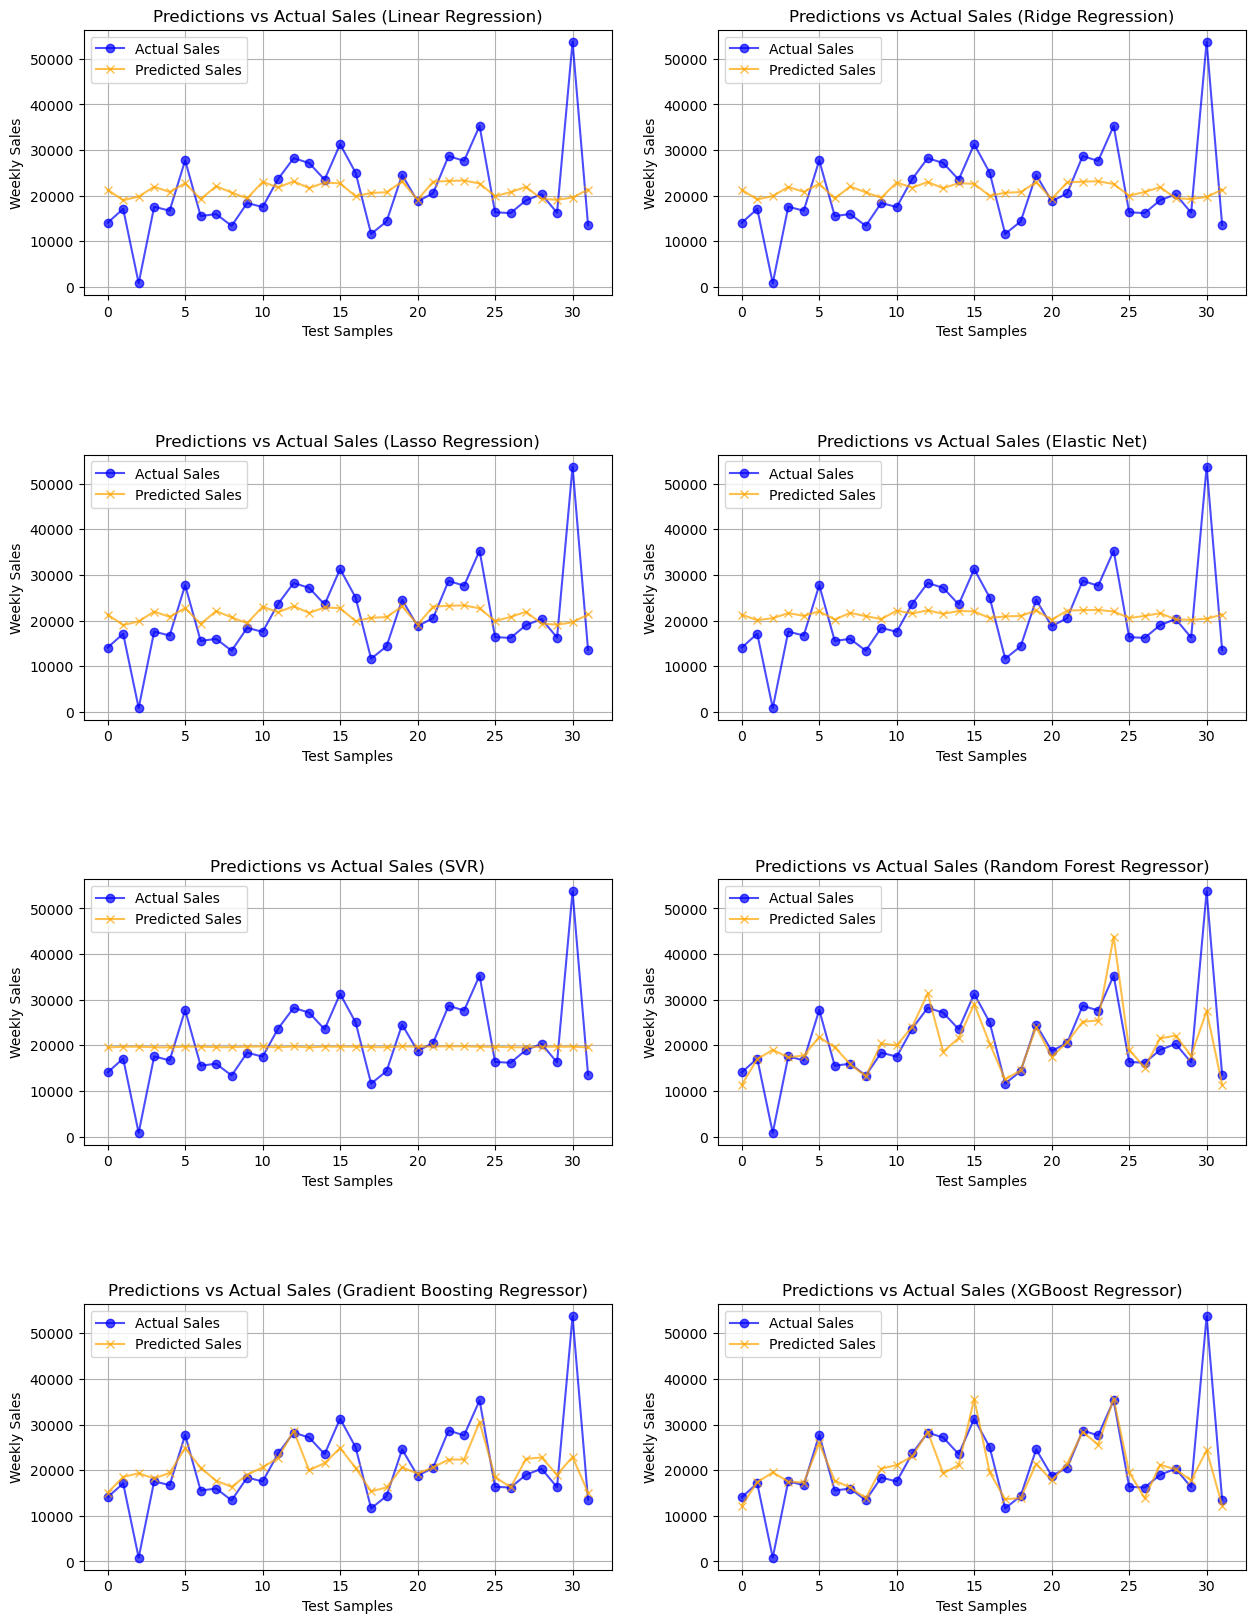

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
data = pd.read_csv(r'C:\Users\varad\Downloads\weekly_sales.csv')
df = pd.DataFrame(data)

# Features (X) and target (y)
X = df[['Week']].values
y = df['Sales'].values

# Normalize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Define regression models and their hyperparameters
param_grids = {
    "Linear Regression": {},
    "Ridge Regression": {'alpha': [0.1, 1.0, 10.0]},
    "Lasso Regression": {'alpha': [0.01, 0.1, 1.0]},
    "Elastic Net": {'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.1, 0.5, 0.9]},
    "SVR": {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.2]},
    "Random Forest Regressor": {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    },
    "Gradient Boosting Regressor": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "XGBoost Regressor": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'colsample_bytree': [0.5, 0.7, 1.0]
    }
}

# Dictionary to store best models and results
best_models = {}

# Ensure y_test is a Pandas Series for plotting
try:
    y_test_series = pd.Series(y_test)
except AttributeError:
    y_test_series = y_test

# Train and test each model with GridSearchCV
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
plt.subplots_adjust(hspace=0.6)

for idx, (name, param_grid) in enumerate(param_grids.items()):
    # Model instance
    if name == "SVR":
        model = SVR()
    elif name == "XGBoost Regressor":
        model = XGBRegressor(objective='reg:squarederror', random_state=42)
    else:
        model = {
            "Linear Regression": LinearRegression(),
            "Ridge Regression": Ridge(),
            "Lasso Regression": Lasso(),
            "Elastic Net": ElasticNet(),
            "Random Forest Regressor": RandomForestRegressor(),
            "Gradient Boosting Regressor": GradientBoostingRegressor()
        }[name]
    
    # GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"--- {name} ---")
    print("Best Params:", grid_search.best_params_)
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    
    # Plot actual vs predicted sales
    ax = axs[idx // 2, idx % 2]
    ax.plot(y_test_series, label="Actual Sales", color="blue", alpha=0.7, marker="o")
    ax.plot(y_pred, label="Predicted Sales", color="orange", alpha=0.7, marker="x")
    ax.set_title(f"Predictions vs Actual Sales ({name})")
    ax.set_xlabel("Test Samples")
    ax.set_ylabel("Weekly Sales")
    ax.legend()
    ax.grid(True)

plt.show()





Enter the date column name (if applicable, else press Enter):  


Fitting 5 folds for each of 1 candidates, totalling 5 fits
--- Linear Regression ---
Best Params: {}
Mean Squared Error: 74641037.68779638
R-squared Score: 0.06693166816179696
Fitting 5 folds for each of 3 candidates, totalling 15 fits
--- Ridge Regression ---
Best Params: {'alpha': 10.0}
Mean Squared Error: 74904252.29506099
R-squared Score: 0.06364129034653798
Fitting 5 folds for each of 3 candidates, totalling 15 fits
--- Lasso Regression ---
Best Params: {'alpha': 1.0}
Mean Squared Error: 74643581.272419
R-squared Score: 0.06689987146745513
Fitting 5 folds for each of 9 candidates, totalling 45 fits
--- Elastic Net ---
Best Params: {'alpha': 1.0, 'l1_ratio': 0.1}
Mean Squared Error: 76742172.04522279
R-squared Score: 0.04066593029716481
Fitting 5 folds for each of 9 candidates, totalling 45 fits
--- SVR ---
Best Params: {'C': 10, 'epsilon': 0.01}
Mean Squared Error: 81197143.2627153
R-squared Score: -0.015024514142792045
Fitting 5 folds for each of 27 candidates, totalling 135 fits

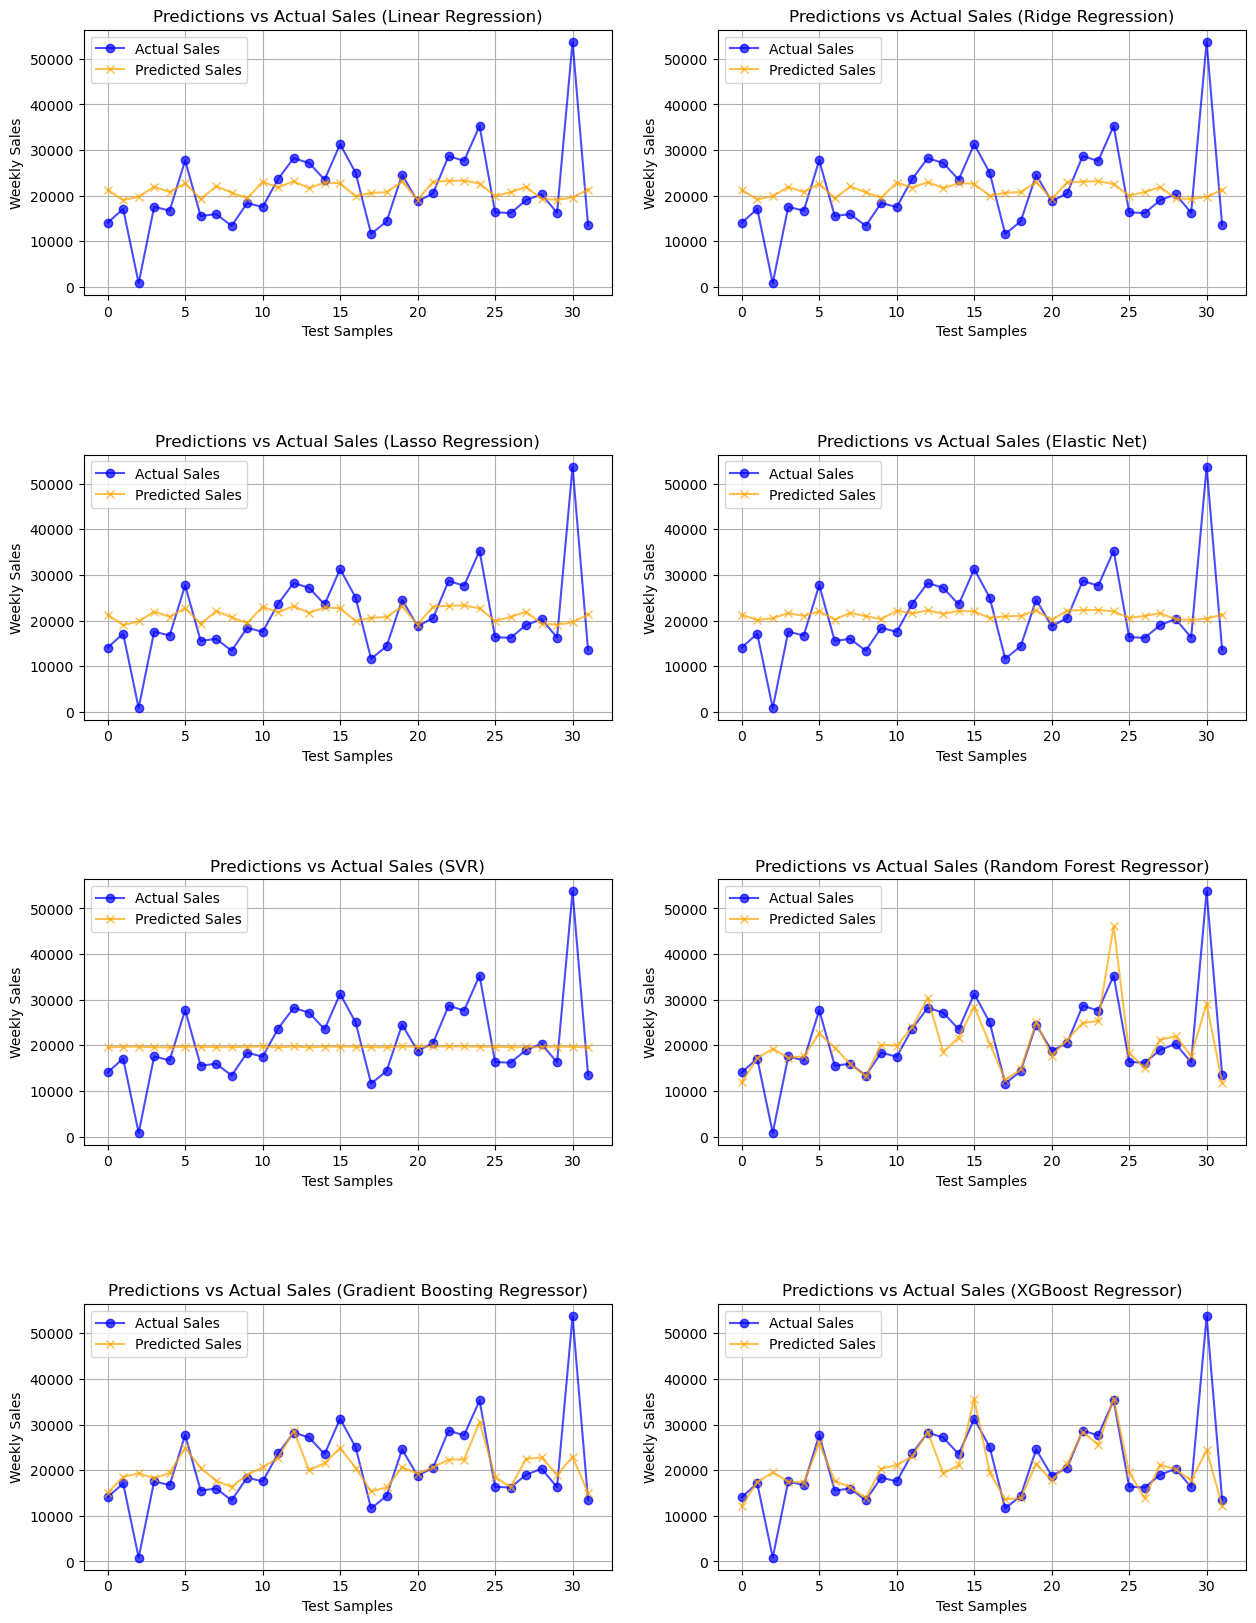

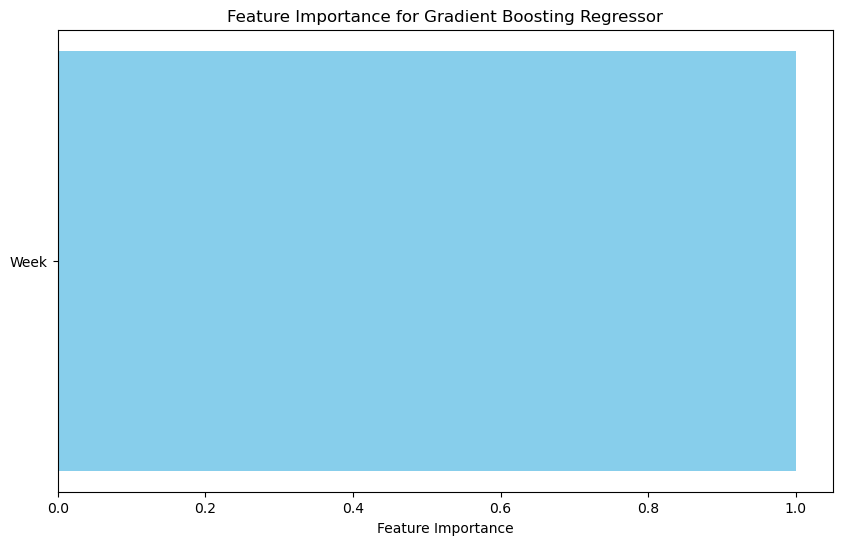

In [82]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to load the dataset and process it
def load_and_process_data(file_path, date_column=None):
    # Load dataset from user-provided file path
    data = pd.read_csv(file_path)
    
    # Check if there's a date column and process it to extract weeks and months
    if date_column and date_column in data.columns:
        data['week'] = data[date_column].dt.isocalendar().week.astype(int)
        data['month'] = data[date_column].dt.month
        data['year'] = data[date_column].dt.year
        data['is_weekend'] = (data[date_column].dt.dayofweek >= 5).astype(int)
    
    # Separate features (independent variables) and target (dependent variable)
    X = data.drop(columns=['Sales'])  # Remove the target variable (Sales)
    y = data['Sales']  # Sales is the dependent variable
    
    return X, y

# Function to train and evaluate models
def train_and_evaluate_models(X, y, models, param_grids, test_size=0.2):
    # Normalize the features
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=test_size, random_state=42)

    # Dictionary to store best models and results
    best_models = {}

    y_test_series = pd.Series(y_test)

    # Train and test each model with GridSearchCV
    fig, axs = plt.subplots(4, 2, figsize=(15, 20))
    plt.subplots_adjust(hspace=0.6)

    for idx, (name, model) in enumerate(models.items()):
        # GridSearchCV
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
        grid_search.fit(X_train, y_train)

        # Best model
        best_model = grid_search.best_estimator_
        best_models[name] = best_model

        # Predictions
        y_pred = best_model.predict(X_test)

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"--- {name} ---")
        print("Best Params:", grid_search.best_params_)
        print("Mean Squared Error:", mse)
        print("R-squared Score:", r2)

        # Plot actual vs predicted sales
        ax = axs[idx // 2, idx % 2]
        ax.plot(y_test.reset_index(drop=True), label="Actual Sales", color="blue", alpha=0.7, marker="o")
        ax.plot(y_pred, label="Predicted Sales", color="orange", alpha=0.7, marker="x")
        ax.set_title(f"Predictions vs Actual Sales ({name})")
        ax.set_xlabel("Test Samples")
        ax.set_ylabel("Weekly Sales")
        ax.legend()
        ax.grid(True)

    plt.show()

    # Returning the best models for external use
    return best_models

# Function to run the entire process
def main():
    # Load the dataset
    file_path = r'C:\Users\varad\Downloads\weekly_sales.csv'
    date_column = input("Enter the date column name (if applicable, else press Enter): ")

    # Load and process data
    X, y = load_and_process_data(file_path, date_column)

    # Define regression models and their hyperparameters
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(),
        "Lasso Regression": Lasso(),
        "Elastic Net": ElasticNet(),
        "SVR": SVR(),
        "Random Forest Regressor": RandomForestRegressor(),
        "Gradient Boosting Regressor": GradientBoostingRegressor(),
        "XGBoost Regressor": XGBRegressor(objective='reg:squarederror', random_state=42)
    }

    param_grids = {
        "Linear Regression": {},
        "Ridge Regression": {'alpha': [0.1, 1.0, 10.0]},
        "Lasso Regression": {'alpha': [0.01, 0.1, 1.0]},
        "Elastic Net": {'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.1, 0.5, 0.9]},
        "SVR": {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.2]},
        "Random Forest Regressor": {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10]
        },
        "Gradient Boosting Regressor": {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        },
        "XGBoost Regressor": {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'colsample_bytree': [0.5, 0.7, 1.0]
        }
    }

    # Train and evaluate models
    best_models = train_and_evaluate_models(X, y, models, param_grids)

    # Display feature importances for the best model
    best_model_name = "Gradient Boosting Regressor"  # Modify based on your best model
    if best_model_name in best_models:
        best_model = best_models[best_model_name]
        importances = best_model.feature_importances_
        feature_names = X.columns

        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.barh(feature_names, importances, color='skyblue')
        plt.xlabel('Feature Importance')
        plt.title(f'Feature Importance for {best_model_name}')
        plt.show()

if __name__ == "__main__":
    main()


Enter the date column name (if applicable, else press Enter):  
Do you want to apply lag features? (yes/no):  Yes
Enter lag feature values separated by commas (e.g., 1,2,3):  3


--- Linear Regression ---
Mean Squared Error: 176650098.20958382
R-squared Score: 0.0965168911886074
Fitting 5 folds for each of 3 candidates, totalling 15 fits
--- Ridge Regression ---
Best Params: {'alpha': 10.0}
Mean Squared Error: 177778092.01554614
R-squared Score: 0.0907477273961157
Fitting 5 folds for each of 3 candidates, totalling 15 fits
--- Lasso Regression ---
Best Params: {'alpha': 0.01}
Mean Squared Error: 176650197.14868632
R-squared Score: 0.0965163851611055
Fitting 5 folds for each of 9 candidates, totalling 45 fits
--- Elastic Net ---
Best Params: {'alpha': 1.0, 'l1_ratio': 0.9}
Mean Squared Error: 178040140.86108357
R-squared Score: 0.08940746940573696
Fitting 5 folds for each of 9 candidates, totalling 45 fits
--- SVR ---
Best Params: {'C': 10, 'epsilon': 0.01}
Mean Squared Error: 200298613.71936184
R-squared Score: -0.02443426891886835
Fitting 5 folds for each of 27 candidates, totalling 135 fits
--- Random Forest Regressor ---
Best Params: {'max_depth': 7, 'min_sa

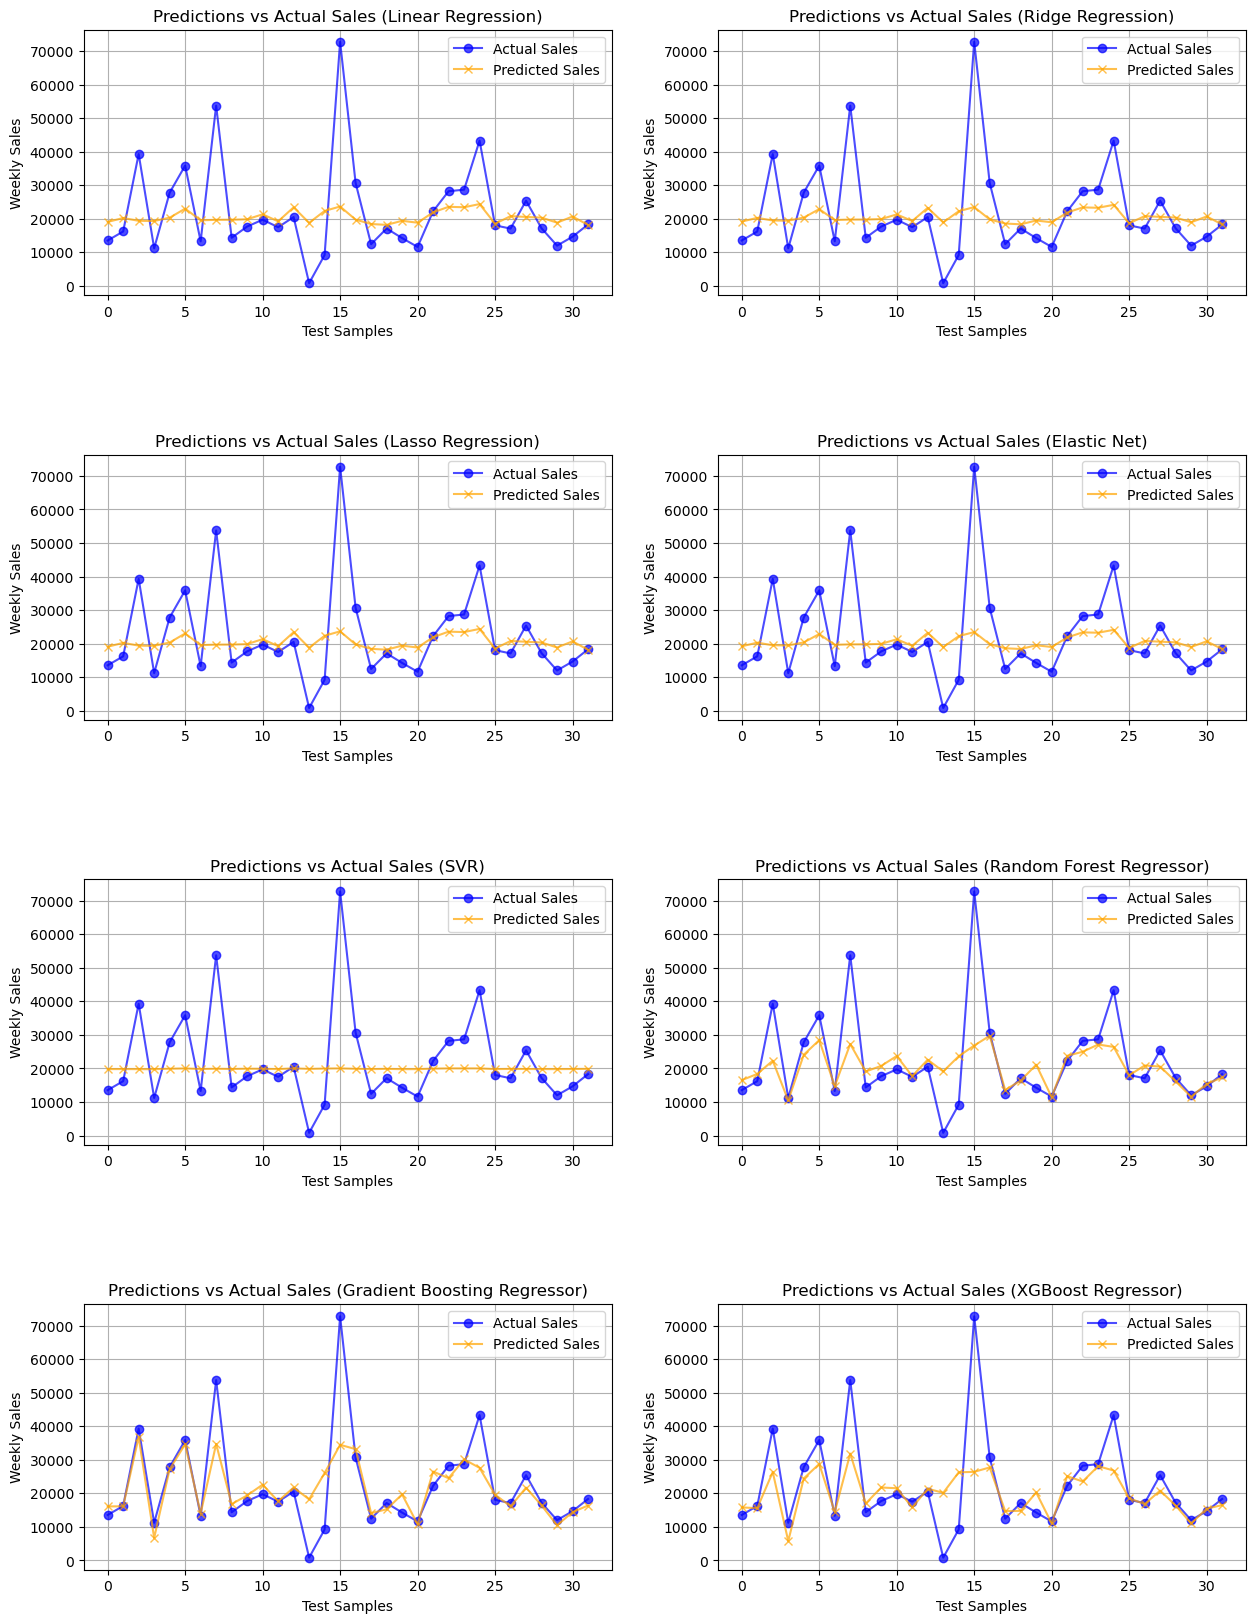

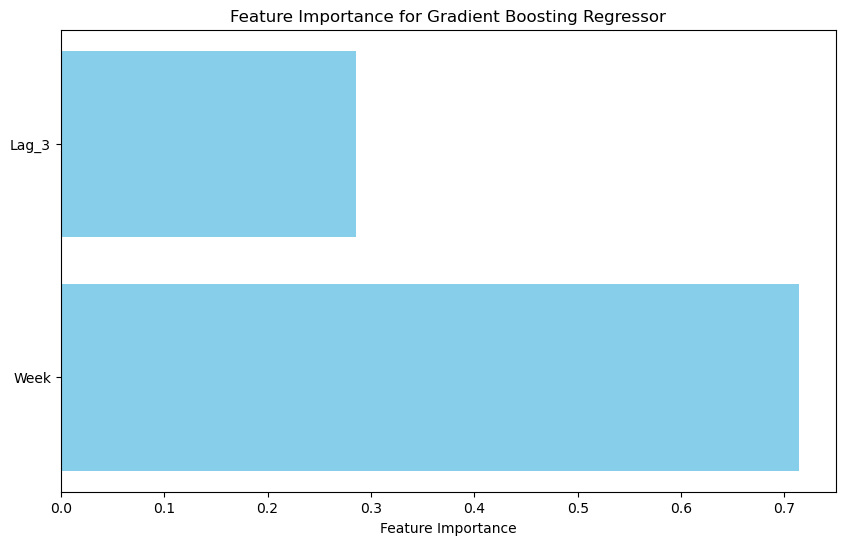

In [84]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to load the dataset and process it
def load_and_process_data(file_path, date_column=None, apply_lag=False, lag_features=None):
    # Load dataset from user-provided file path
    data = pd.read_csv(file_path)
    
    # If a date column is provided, extract week, month, year, and weekend features
    if date_column and date_column in data.columns:
        data['week'] = data[date_column].dt.isocalendar().week.astype(int)
        data['month'] = data[date_column].dt.month
        data['year'] = data[date_column].dt.year
        data['is_weekend'] = (data[date_column].dt.dayofweek >= 5).astype(int)

    # Optionally apply lag features
    if apply_lag:
        for lag in lag_features:
            data[f'Lag_{lag}'] = data['Sales'].shift(lag)
        data.dropna(inplace=True)
    
    # Separate features (independent variables) and target (dependent variable)
    X = data.drop(columns=['Sales'])  # Remove the target variable (Sales)
    y = data['Sales']  # Sales is the dependent variable
    
    return X, y

# Function to train and evaluate models
def train_and_evaluate_models(X, y, models, param_grids, test_size=0.2):
    # Normalize the features
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=test_size, random_state=42)

    # Dictionary to store best models and results
    best_models = {}

    y_test_series = pd.Series(y_test)

    # Train and test each model with GridSearchCV
    fig, axs = plt.subplots(4, 2, figsize=(15, 20))
    plt.subplots_adjust(hspace=0.6)

    for idx, (name, model) in enumerate(models.items()):
        if param_grids[name]:
            grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
            grid_search.fit(X_train, y_train)

            # Best model
            best_model = grid_search.best_estimator_
            best_models[name] = best_model

            # Predictions
            y_pred = best_model.predict(X_test)

            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            print(f"--- {name} ---")
            print("Best Params:", grid_search.best_params_)
            print("Mean Squared Error:", mse)
            print("R-squared Score:", r2)
        else:
            # Train without GridSearchCV
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            print(f"--- {name} ---")
            print("Mean Squared Error:", mse)
            print("R-squared Score:", r2)
            best_models[name] = model

        # Plot actual vs predicted sales
        ax = axs[idx // 2, idx % 2]
        ax.plot(y_test.reset_index(drop=True), label="Actual Sales", color="blue", alpha=0.7, marker="o")
        ax.plot(y_pred, label="Predicted Sales", color="orange", alpha=0.7, marker="x")
        ax.set_title(f"Predictions vs Actual Sales ({name})")
        ax.set_xlabel("Test Samples")
        ax.set_ylabel("Weekly Sales")
        ax.legend()
        ax.grid(True)

    plt.show()

    # Returning the best models for external use
    return best_models

# Function to run the entire process
def main():
    # Load the dataset
    file_path = r'C:\Users\varad\Downloads\weekly_sales.csv'
    date_column = input("Enter the date column name (if applicable, else press Enter): ")

    # Option to choose whether to apply lag features or not
    apply_lag = input("Do you want to apply lag features? (yes/no): ").strip().lower() == 'yes'
    lag_features = []
    if apply_lag:
        lag_features = list(map(int, input("Enter lag feature values separated by commas (e.g., 1,2,3): ").split(',')))

    # Load and process data
    X, y = load_and_process_data(file_path, date_column, apply_lag, lag_features)

    # Define regression models and their hyperparameters
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(),
        "Lasso Regression": Lasso(),
        "Elastic Net": ElasticNet(),
        "SVR": SVR(),
        "Random Forest Regressor": RandomForestRegressor(),
        "Gradient Boosting Regressor": GradientBoostingRegressor(),
        "XGBoost Regressor": XGBRegressor(objective='reg:squarederror', random_state=42)
    }

    param_grids = {
        "Linear Regression": None,
        "Ridge Regression": {'alpha': [0.1, 1.0, 10.0]},
        "Lasso Regression": {'alpha': [0.01, 0.1, 1.0]},
        "Elastic Net": {'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.1, 0.5, 0.9]},
        "SVR": {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.2]},
        "Random Forest Regressor": {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10]
        },
        "Gradient Boosting Regressor": {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        },
        "XGBoost Regressor": {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'colsample_bytree': [0.5, 0.7, 1.0]
        }
    }

    # Train and evaluate models
    best_models = train_and_evaluate_models(X, y, models, param_grids)

    # Display feature importances for the best model
    best_model_name = "Gradient Boosting Regressor"  # Modify based on your best model
    if best_model_name in best_models:
        best_model = best_models[best_model_name]
        importances = best_model.feature_importances_
        feature_names = X.columns

        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.barh(feature_names, importances, color='skyblue')
        plt.xlabel('Feature Importance')
        plt.title(f'Feature Importance for {best_model_name}')
        plt.show()

if __name__ == "__main__":
    main()


Enter the date column name (if applicable, else press Enter):  
Do you want to apply lag features? (yes/no):  no
Do you want to perform hyperparameter tuning? (yes/no):  no


--- Linear Regression ---
Mean Squared Error: 74641037.68779638
R-squared Score: 0.06693166816179696
--- Ridge Regression ---
Mean Squared Error: 74668113.53280513
R-squared Score: 0.06659320001722091
--- Lasso Regression ---
Mean Squared Error: 74643581.272419
R-squared Score: 0.06689987146745513
--- Elastic Net ---
Mean Squared Error: 76025986.80769743
R-squared Score: 0.0496187769558627
--- SVR ---
Mean Squared Error: 81452521.00673112
R-squared Score: -0.018216925354894054
--- Random Forest Regressor ---
Mean Squared Error: 35845190.79837092
R-squared Score: 0.5519085288905838
--- Gradient Boosting Regressor ---
Mean Squared Error: 46302194.23625605
R-squared Score: 0.42118823002998673
--- XGBoost Regressor ---
Mean Squared Error: 40111681.897291705
R-squared Score: 0.49857422572717225


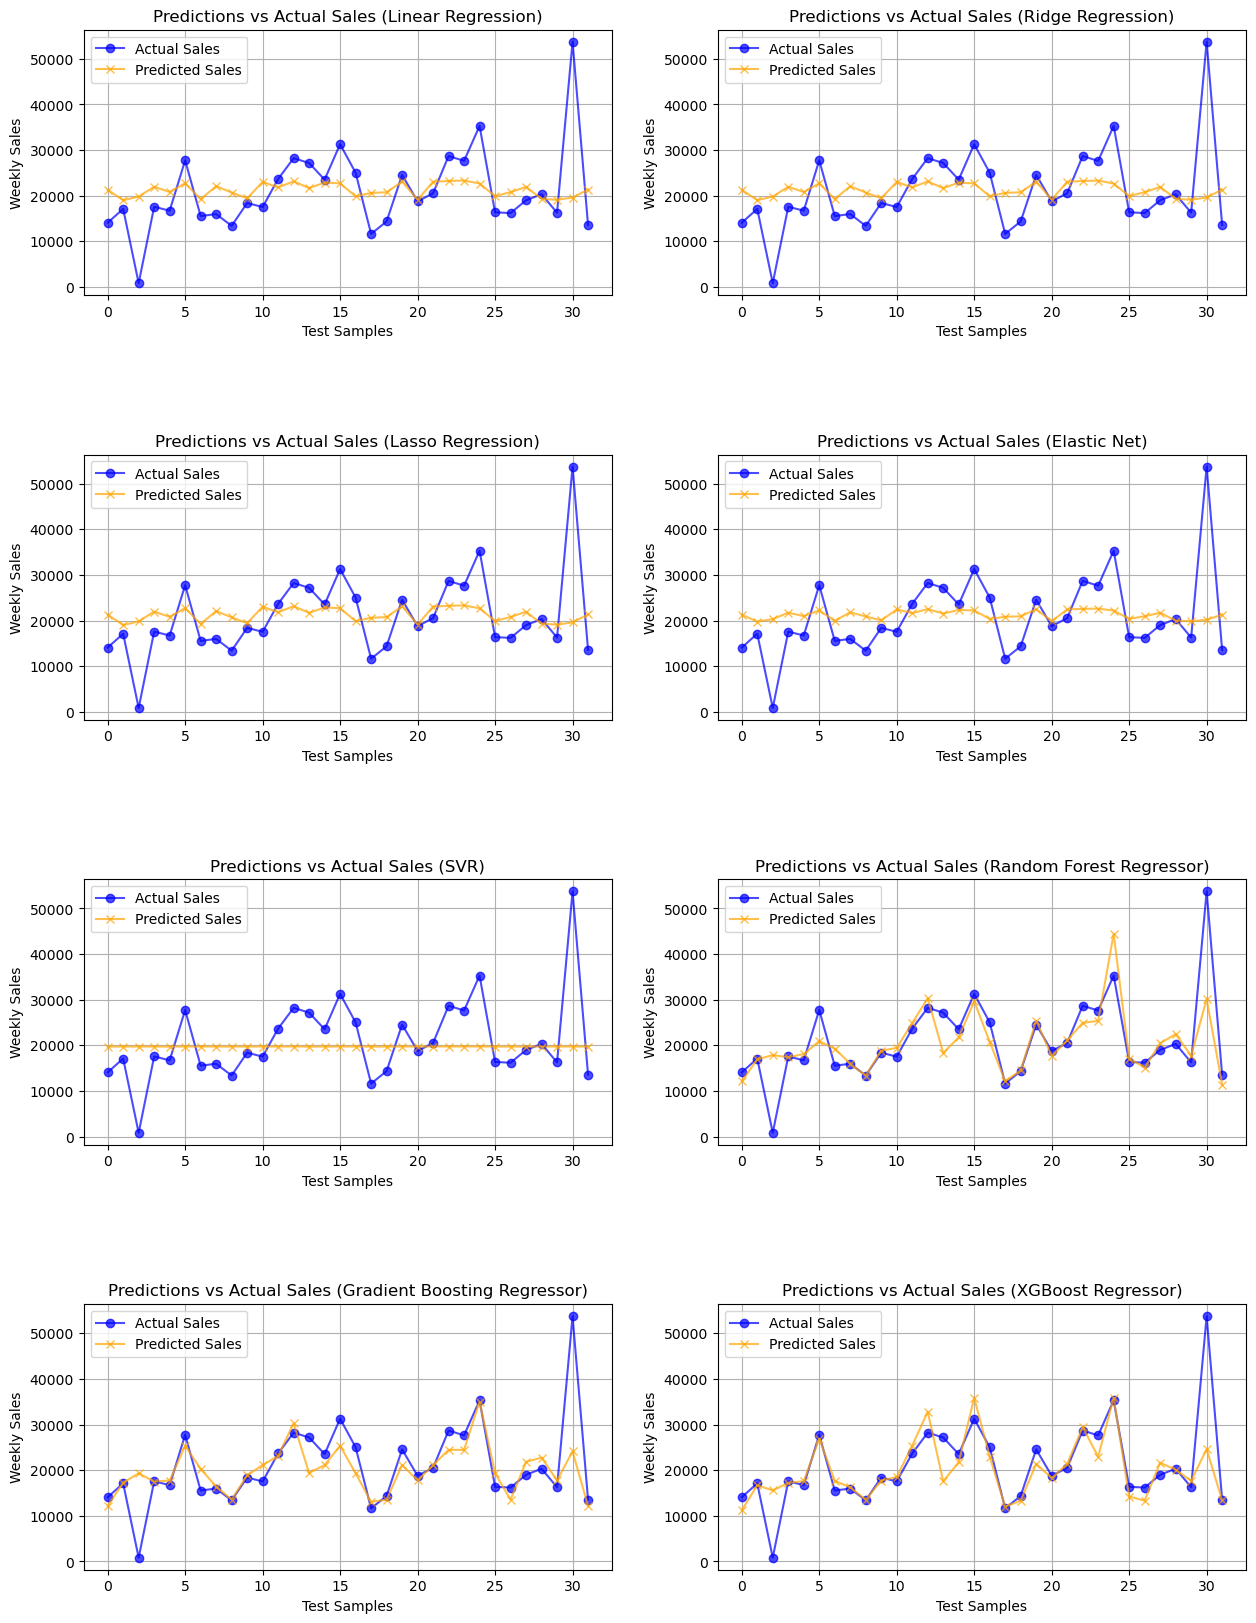

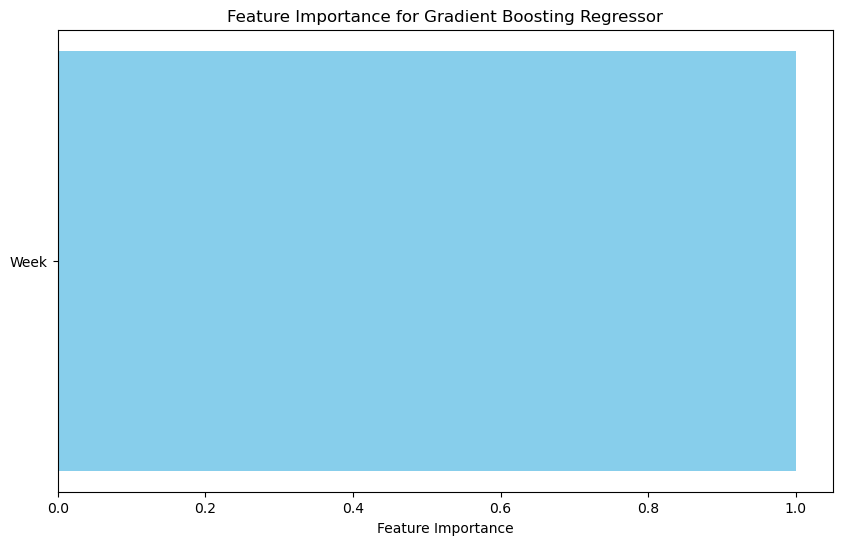

In [86]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to load the dataset and process it
def load_and_process_data(file_path, date_column=None, apply_lag=False, lag_features=None):
    # Load dataset from user-provided file path
    data = pd.read_csv(file_path)
    
    # If a date column is provided, extract week, month, year, and weekend features
    if date_column and date_column in data.columns:
        data['week'] = data[date_column].dt.isocalendar().week.astype(int)
        data['month'] = data[date_column].dt.month
        data['year'] = data[date_column].dt.year
        data['is_weekend'] = (data[date_column].dt.dayofweek >= 5).astype(int)

    # Optionally apply lag features
    if apply_lag:
        for lag in lag_features:
            data[f'Lag_{lag}'] = data['Sales'].shift(lag)
        data.dropna(inplace=True)
    
    # Separate features (independent variables) and target (dependent variable)
    X = data.drop(columns=['Sales'])  # Remove the target variable (Sales)
    y = data['Sales']  # Sales is the dependent variable
    
    return X, y

# Function to train and evaluate models
def train_and_evaluate_models(X, y, models, param_grids, test_size=0.2, hyperparameter_tuning=True):
    # Normalize the features
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=test_size, random_state=42)

    # Dictionary to store best models and results
    best_models = {}

    y_test_series = pd.Series(y_test)

    # Train and test each model with or without GridSearchCV based on hyperparameter_tuning
    fig, axs = plt.subplots(4, 2, figsize=(15, 20))
    plt.subplots_adjust(hspace=0.6)

    for idx, (name, model) in enumerate(models.items()):
        if hyperparameter_tuning and param_grids[name]:
            grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
            grid_search.fit(X_train, y_train)

            # Best model
            best_model = grid_search.best_estimator_
            best_models[name] = best_model

            # Predictions
            y_pred = best_model.predict(X_test)

            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            print(f"--- {name} ---")
            print("Best Params:", grid_search.best_params_)
            print("Mean Squared Error:", mse)
            print("R-squared Score:", r2)
        else:
            # Train without GridSearchCV
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            print(f"--- {name} ---")
            print("Mean Squared Error:", mse)
            print("R-squared Score:", r2)
            best_models[name] = model

        # Plot actual vs predicted sales
        ax = axs[idx // 2, idx % 2]
        ax.plot(y_test.reset_index(drop=True), label="Actual Sales", color="blue", alpha=0.7, marker="o")
        ax.plot(y_pred, label="Predicted Sales", color="orange", alpha=0.7, marker="x")
        ax.set_title(f"Predictions vs Actual Sales ({name})")
        ax.set_xlabel("Test Samples")
        ax.set_ylabel("Weekly Sales")
        ax.legend()
        ax.grid(True)

    plt.show()

    # Returning the best models for external use
    return best_models

# Function to run the entire process
def main():
    # Load the dataset
    file_path = r'C:\Users\varad\Downloads\weekly_sales.csv'
    date_column = input("Enter the date column name (if applicable, else press Enter): ")

    # Option to choose whether to apply lag features or not
    apply_lag = input("Do you want to apply lag features? (yes/no): ").strip().lower() == 'yes'
    lag_features = []
    if apply_lag:
        lag_features = list(map(int, input("Enter lag feature values separated by commas (e.g., 1,2,3): ").split(',')))

    # Load and process data
    X, y = load_and_process_data(file_path, date_column, apply_lag, lag_features)

    # Ask if they want hyperparameter tuning
    hyperparameter_tuning = input("Do you want to perform hyperparameter tuning? (yes/no): ").strip().lower() == 'yes'

    # Define regression models and their hyperparameters
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(),
        "Lasso Regression": Lasso(),
        "Elastic Net": ElasticNet(),
        "SVR": SVR(),
        "Random Forest Regressor": RandomForestRegressor(),
        "Gradient Boosting Regressor": GradientBoostingRegressor(),
        "XGBoost Regressor": XGBRegressor(objective='reg:squarederror', random_state=42)
    }

    param_grids = {
        "Linear Regression": None,
        "Ridge Regression": {'alpha': [0.1, 1.0, 10.0]},
        "Lasso Regression": {'alpha': [0.01, 0.1, 1.0]},
        "Elastic Net": {'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.1, 0.5, 0.9]},
        "SVR": {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.2]},
        "Random Forest Regressor": {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10]
        },
        "Gradient Boosting Regressor": {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        },
        "XGBoost Regressor": {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'colsample_bytree': [0.5, 0.7, 1.0]
        }
    }

    # Train and evaluate models
    best_models = train_and_evaluate_models(X, y, models, param_grids, hyperparameter_tuning=hyperparameter_tuning)

    # Display feature importances for the best model
    best_model_name = "Gradient Boosting Regressor"  # Modify based on your best model
    if best_model_name in best_models:
        best_model = best_models[best_model_name]
        importances = best_model.feature_importances_
        feature_names = X.columns

        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.barh(feature_names, importances, color='skyblue')
        plt.xlabel('Feature Importance')
        plt.title(f'Feature Importance for {best_model_name}')
        plt.show()

if __name__ == "__main__":
    main()


Enter the date column name (if applicable, else press Enter):  
Do you want to apply lag features? (yes/no):  no
Do you want to perform hyperparameter tuning? (yes/no):  no


C:\Users\varad\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\varad\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\varad\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\varad\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

--- Linear Regression ---
Mean Squared Error: 74641037.68779638
Root Mean Squared Error: 8639.504481612148
R-squared Score: 0.06693166816179696
--- Ridge Regression ---
Mean Squared Error: 74668113.53280513
Root Mean Squared Error: 8641.071318581113
R-squared Score: 0.06659320001722091
--- Lasso Regression ---
Mean Squared Error: 74643581.272419
Root Mean Squared Error: 8639.651686984784
R-squared Score: 0.06689987146745513
--- Elastic Net ---
Mean Squared Error: 76025986.80769743
Root Mean Squared Error: 8719.288205335195
R-squared Score: 0.0496187769558627
--- SVR ---
Mean Squared Error: 81452521.00673112
Root Mean Squared Error: 9025.105041312878
R-squared Score: -0.018216925354894054


C:\Users\varad\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\varad\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\varad\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


--- Random Forest Regressor ---
Mean Squared Error: 35952501.51546724
Root Mean Squared Error: 5996.040486476659
R-squared Score: 0.5505670653352641
--- Gradient Boosting Regressor ---
Mean Squared Error: 46302194.23625605
Root Mean Squared Error: 6804.571568898078
R-squared Score: 0.42118823002998673
--- XGBoost Regressor ---
Mean Squared Error: 40111681.897291705
Root Mean Squared Error: 6333.3783952399135
R-squared Score: 0.49857422572717225


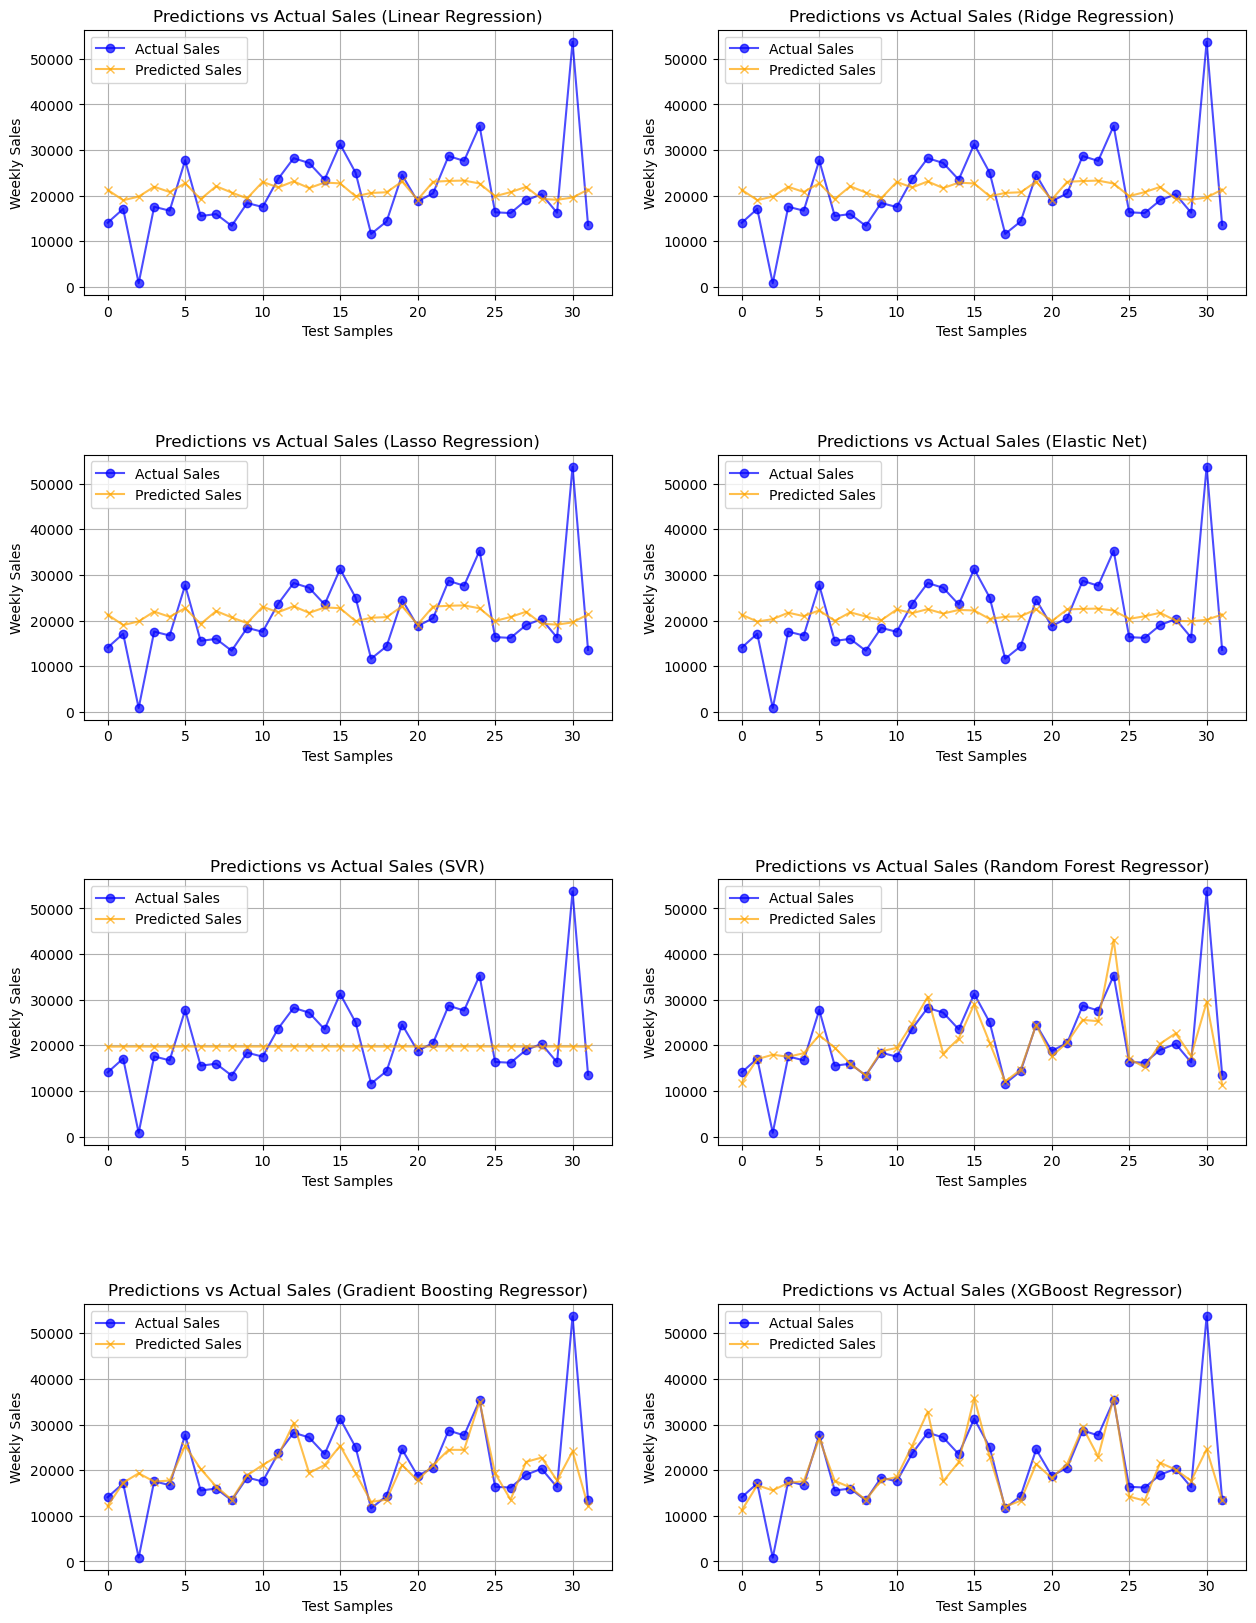

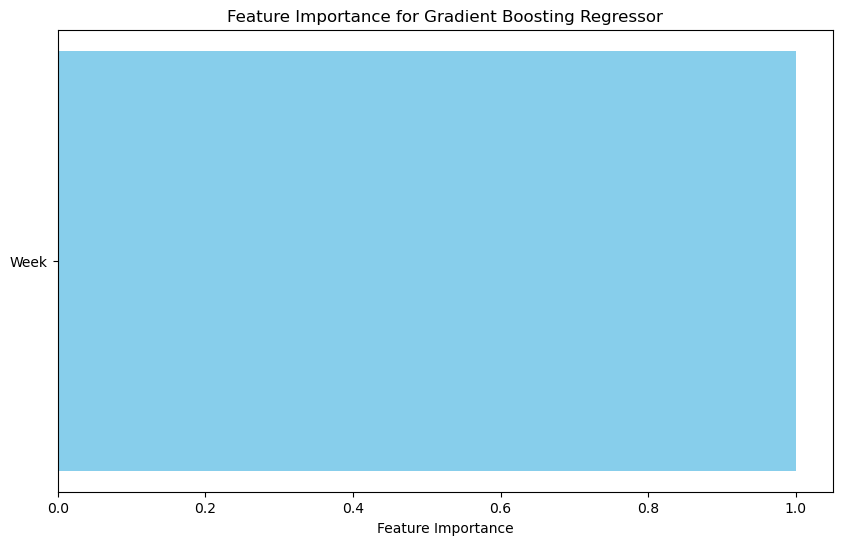

In [91]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
import matplotlib.pyplot as plt

# Function to load the dataset and process it
def load_and_process_data(file_path, date_column=None, apply_lag=False, lag_features=None):
    # Load dataset from user-provided file path
    data = pd.read_csv(file_path)
    
    # If a date column is provided, extract week, month, year, and weekend features
    if date_column and date_column in data.columns:
        data['week'] = data[date_column].dt.isocalendar().week.astype(int)
        data['month'] = data[date_column].dt.month
        data['year'] = data[date_column].dt.year
        data['is_weekend'] = (data[date_column].dt.dayofweek >= 5).astype(int)

    # Optionally apply lag features
    if apply_lag:
        for lag in lag_features:
            data[f'Lag_{lag}'] = data['Sales'].shift(lag)
        data.dropna(inplace=True)
    
    # Separate features (independent variables) and target (dependent variable)
    X = data.drop(columns=['Sales'])  # Remove the target variable (Sales)
    y = data['Sales']  # Sales is the dependent variable
    
    return X, y

# Function to train and evaluate models
def train_and_evaluate_models(X, y, models, param_grids, test_size=0.2, hyperparameter_tuning=True):
    # Normalize the features
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=test_size, random_state=42)

    # Dictionary to store best models and results
    best_models = {}

    y_test_series = pd.Series(y_test)

    # Train and test each model with or without GridSearchCV based on hyperparameter_tuning
    fig, axs = plt.subplots(4, 2, figsize=(15, 20))
    plt.subplots_adjust(hspace=0.6)

    for idx, (name, model) in enumerate(models.items()):
        if hyperparameter_tuning and param_grids[name]:
            grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
            grid_search.fit(X_train, y_train)

            # Best model
            best_model = grid_search.best_estimator_
            best_models[name] = best_model

            # Predictions
            y_pred = best_model.predict(X_test)

            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)
            rmse = mean_squared_error(y_test, y_pred, squared=False)
            r2 = r2_score(y_test, y_pred)

            print(f"--- {name} ---")
            print("Best Params:", grid_search.best_params_)
            print("Mean Squared Error:", mse)
            print("Root Mean Squared Error:", rmse)
            print("R-squared Score:", r2)
        else:
            # Train without GridSearchCV
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            rmse = mean_squared_error(y_test, y_pred, squared=False)
            r2 = r2_score(y_test, y_pred)

            print(f"--- {name} ---")
            print("Mean Squared Error:", mse)
            print("Root Mean Squared Error:", rmse)
            print("R-squared Score:", r2)
            best_models[name] = model

        # Plot actual vs predicted sales
        ax = axs[idx // 2, idx % 2]
        ax.plot(y_test.reset_index(drop=True), label="Actual Sales", color="blue", alpha=0.7, marker="o")
        ax.plot(y_pred, label="Predicted Sales", color="orange", alpha=0.7, marker="x")
        ax.set_title(f"Predictions vs Actual Sales ({name})")
        ax.set_xlabel("Test Samples")
        ax.set_ylabel("Weekly Sales")
        ax.legend()
        ax.grid(True)

    plt.show()

    # Returning the best models for external use
    return best_models

# Function to run the entire process
def main():
    # Load the dataset
    file_path = r'C:\Users\varad\Downloads\weekly_sales.csv'
    date_column = input("Enter the date column name (if applicable, else press Enter): ")

    # Option to choose whether to apply lag features or not
    apply_lag = input("Do you want to apply lag features? (yes/no): ").strip().lower() == 'yes'
    lag_features = []
    if apply_lag:
        lag_features = list(map(int, input("Enter lag feature values separated by commas (e.g., 1,2,3): ").split(',')))

    # Load and process data
    X, y = load_and_process_data(file_path, date_column, apply_lag, lag_features)

    # Ask if they want hyperparameter tuning
    hyperparameter_tuning = input("Do you want to perform hyperparameter tuning? (yes/no): ").strip().lower() == 'yes'

    # Define regression models and their hyperparameters
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(),
        "Lasso Regression": Lasso(),
        "Elastic Net": ElasticNet(),
        "SVR": SVR(),
        "Random Forest Regressor": RandomForestRegressor(),
        "Gradient Boosting Regressor": GradientBoostingRegressor(),
        "XGBoost Regressor": XGBRegressor(objective='reg:squarederror', random_state=42)
    }

    param_grids = {
        "Linear Regression": None,
        "Ridge Regression": {'alpha': [0.1, 1.0, 10.0]},
        "Lasso Regression": {'alpha': [0.01, 0.1, 1.0]},
        "Elastic Net": {'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.1, 0.5, 0.9]},
        "SVR": {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.2]},
        "Random Forest Regressor": {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10]
        },
        "Gradient Boosting Regressor": {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        },
        "XGBoost Regressor": {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'colsample_bytree': [0.5, 0.7, 1.0]
        }
    }

    # Train and evaluate models
    best_models = train_and_evaluate_models(X, y, models, param_grids, hyperparameter_tuning=hyperparameter_tuning)

    # Display feature importances for the best model
    best_model_name = "Gradient Boosting Regressor"  # Modify based on your best model
    if best_model_name in best_models:
        best_model = best_models[best_model_name]
        importances = best_model.feature_importances_
        feature_names = X.columns

        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.barh(feature_names, importances, color='skyblue')
        plt.xlabel('Feature Importance')
        plt.title(f'Feature Importance for {best_model_name}')
        plt.show()

if __name__ == "__main__":
    main()
